(Beginning of Milestone 2)

# Importing the data

In order to import the datasets needed and compute operations we firstly need to import python packages and connect the notebook to our Google Drive directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In particular we need to set the Pandas version to 1.0.5 in order to work with Quotebank chunks.

In [ ]:
!pip install pandas==1.0.5

     |████████████████████████████████| 10.1 MB 4.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We start by looking at smaller chunks to prepare a data cleaning pipeline. To load the dataset we import it in different smaller chunks, otherwise, due to its size, it wouldn't be possible load it.

In [ ]:
# Here we load into memory just the first chunk to take a look at the data and use it to prepare a cleaning pipeline that will
# be used for our entire final dataset
df_reader = pd.read_json('/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=1000000)
for chunk in df_reader:
   chunk_test = chunk
   break

In [ ]:
chunk_test.columns

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

In [ ]:
chunk_test.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


we can already see that for our analysis we will need just six columns, so we will import just them in future to lower the computational cost of the import and facilitate it.

In [ ]:
chunk_test.drop(['date', 'urls', 'phase'], axis = 1, inplace=True)

Now we import the speakers' attributes to be able to select those who we are interested in

In [ ]:
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet')

In [ ]:
speaker_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


We can already drop some columns that we will not use for sure.

In [ ]:
speaker_attributes.drop(['lastrevid', 'type', 'religion'], axis = 1, inplace = True)

In [ ]:
speaker_attributes.columns

Index(['aliases', 'date_of_birth', 'nationality', 'gender', 'ethnic_group',
       'US_congress_bio_ID', 'occupation', 'party', 'academic_degree', 'id',
       'label', 'candidacy'],
      dtype='object')

As you can see all the information in the  `speaker_attributes ` dataframe are econded in terms of QIDs, so we want them in a human-readable fashion, so we import a dataset assigning to each QID a readable label.

In [ ]:
readable = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [ ]:
readable.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [ ]:
readable.loc['Q682443']['Label']

'Episcopal Church'

We want to first of all filter for politicians, so we select Hillary Clinton, for example, to assess which is the QIDs for politicians.

First we get her QID.

In [ ]:
chunk_test.loc[chunk_test['speaker'] == 'Hillary Clinton'].qids.iloc[1]

['Q6294']

Then we used the obtained QID to see among her attributes the column `occupation`.

In [ ]:
speaker_attributes.loc[speaker_attributes['id'] == 'Q6294'].occupation

1135081    [Q82955, Q40348, Q193391, Q36180, Q18814623, Q...
Name: occupation, dtype: object

We see that the first QID in the occupation corresponds to "politician" which is what we are interest into.

In [ ]:
readable.loc['Q82955']['Label']

'politician'

Here we create a mask indicating the rows corresponding to politicians

In [ ]:
# We create a mask dropping the rows with Nan in occupation, as we won't use
# them anyways as we want to keep just rows corresponding to politicians
mask_politicians = speaker_attributes.occupation.dropna().apply(lambda x: 'Q82955' in x)

Now we can get the QIDs corresponding to politicians

In [ ]:
# We drop from the id column the rows containing nans in the occupation column, 
# so that we can apply the mask_ploiticians mask to the id column
qids_politicians = speaker_attributes['id'][~speaker_attributes['occupation'].isna()][mask_politicians]

In [ ]:
qids_politicians

0                 Q23
3                Q207
5                Q368
11               Q815
15               Q946
              ...    
9055974    Q106406546
9055975    Q106406557
9055976    Q106406560
9055977    Q106406571
9055980    Q106406643
Name: id, Length: 657166, dtype: object

Furthermore, we want to focus on US politicias so in the same way as before we retrieve the QIDs associated to American nationality.

Again we need to find the QID corresponding to "American" and we use Hillary Clinton as an example.

In [ ]:
speaker_attributes.loc[speaker_attributes['id'] == 'Q6294'].nationality

1135081    [Q30]
Name: nationality, dtype: object

In [ ]:
readable.loc['Q30']['Label']

'United States of America'

In [ ]:
mask_nationality = speaker_attributes.nationality.dropna().apply(lambda x: 'Q30' in x)
qids_americans = speaker_attributes['id'][~speaker_attributes['nationality'].isna()][mask_nationality]

Before removing the rows corresponding to non-American non-politicians we noticies some oddities in the data: in particular we notice that some quotations have multiple QIDs in the `qids` column. For example it happens with Donald Trump.

In [ ]:
chunk_test.loc[chunk_test['speaker'] == 'Donald Trump'].head()

,quoteID,quotation,speaker,qids,numOccurrences,probas
247,2020-02-19-010736,But I happen to like Prime Minister (Narendra)...,Donald Trump,"[Q22686, Q27947481]",8,"[[Donald Trump, 0.4138], [President Donald Tru..."
3172,2020-01-14-026600,"I didn't know that, no.. I hope she's okay,",Donald Trump,"[Q22686, Q27947481]",1,"[[Donald Trump, 0.5667], [None, 0.335], [Megha..."
6575,2020-02-13-078518,"So a leftist attacks 3 Trump supporters, inclu...",Donald Trump,"[Q22686, Q27947481]",3,"[[Donald Trump, 0.6995], [None, 0.2793], [Kimb..."
6740,2020-03-03-052722,The Democrat establishment is trying to take i...,Donald Trump,"[Q22686, Q27947481]",3,"[[Donald Trump, 0.5689], [President Trump, 0.3..."
8063,2020-01-08-021732,He killed thousands of US troops. He directed ...,Donald Trump,"[Q22686, Q27947481]",1,"[[Donald Trump, 0.9092], [None, 0.0908]]"


To find the cause of the issue we can look at `speaker_attributes` dataset:

In [ ]:
speaker_attributes.loc[speaker_attributes['label'] == 'Donald Trump']

,aliases,date_of_birth,nationality,gender,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy
2267061,"[Donald John Trump, Donald J. Trump, Trump, Th...",[+1946-06-14T00:00:00Z],[Q30],[Q6581097],None,None,"[Q911554, Q557880, Q3427922, Q15980158, Q13152...","[Q29468, Q1897793, Q29552, Q29468, Q29468]",[Q787674],Q22686,Donald Trump,"[Q699872, Q22923830, Q38051523]"
8337605,"[Donald L. Trump, Donald Lynn Trump, Skip Trum...","[+1945-07-31T00:00:00Z, +1945-00-00T00:00:00Z]",[Q30],[Q6581097],None,None,"[Q39631, Q16062369]",None,[Q913404],Q27947481,Donald Trump,None


We can see that there is an issue in the way the `qids` column in the main dataset has been built, indeed to each quotation are assigned all the QIDs of the homonyms.
Since there is no way to fix this issue we decided to include in our filtered dataset only the quotations with a maximum of three assigned QIDs, provided that one of them corresponds to a politician. In this way we avoid to include many quotations from non politicians who just happen to be homonym of a politician but still without losing the quotations when the politician has just few homonyms.

We identify and remove the quotations with maximum three QIDs:

In [ ]:
drop_quotes = chunk_test['qids'].apply(lambda x: len(x) < 4)

In [ ]:
chunk_test_drop = chunk_test[drop_quotes]

We start by creating another mask, this time to be applied to the main dataframe (`chunk_test_drop`). This mask will consist of a combination of other two masks: one indicating rows with quotations by politicians and one with indicating quotations by Americans.

In [ ]:
pos_0 = chunk_test_drop['qids'].str[0].isin(qids_politicians) # We create three masks. Each mask filters for the quotations
pos_1 = chunk_test_drop['qids'].str[1].isin(qids_politicians) # in which the 0th, 1st, 2nd (if multiple) QID respectively, corresponds to
pos_2 = chunk_test_drop['qids'].str[2].isin(qids_politicians) # the QID of a politician

In [ ]:
# We repeat the same procedure as before creating three masks
pos_0_us = chunk_test_drop['qids'].str[0].isin(qids_americans)
pos_1_us = chunk_test_drop['qids'].str[1].isin(qids_americans)
pos_2_us = chunk_test_drop['qids'].str[2].isin(qids_americans)
# Now we can combine the masks point-wise to assess if the QIDs correspond
# to "politician" and "American" at the same time
american_politicians = pos_0_us*pos_0 + pos_1_us*pos_1 + pos_2_us*pos_2

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


Finally we apply the mask to the dataset.

In [ ]:
df = chunk_test_drop[american_politicians]

In [ ]:
df.head()

,quoteID,quotation,speaker,qids,numOccurrences,probas
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy..."
9,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,[Q816459],1,"[[Ben Carson, 0.9227], [None, 0.0773]]"
29,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe..."
33,2020-01-20-000982,a host of other protections,Debbie Lesko,[Q16731415],1,"[[Debbie Lesko, 0.4784], [None, 0.4105], [Ed M..."
37,2020-01-03-001237,A lot of Americans [ were ] upset that this wa...,Julián Castro,[Q970720],1,"[[Julián Castro, 0.4781], [None, 0.4384], [Dav..."


Now that the data are cleaned, we saved the cleaning pipeline in another file .py (avalable in the repo) to be run while importing the data. The reduced size of the cleaned dataset will allow us to be able to work with it in a more convenient way.

Now we want to run some analysis on this dataset, for example what kind of genders are present in the quotes. 
To do so we take the gender column (where we consider only the first QID), we merge it with the redable dataset and we draw a bar chart to which we apply a log scale.

We wish to link each quote with some speaker info. To do this we need a QID associated to the quote and we use it to read the right speaker info in the speaker_attributes_dataset. However, each quote can have more than one QID. 
For this reason we need to once again use some masks to understand which is the QID corresponding to the American politician whose infomration we need to retrieve.

In [ ]:
pos_0_df = df['qids'].str[0].isin(qids_politicians)
pos_1_df = df['qids'].str[1].isin(qids_politicians) 
pos_2_df = df['qids'].str[2].isin(qids_politicians)

In [ ]:
len(df[pos_0_df]) + len(df[pos_1_df]) +len(df[pos_2_df])

81986

The mask is longer than the datasets because there are overlaps.

since for the vast majority of cases, politicans are in the 0-th index, when there are overlaps we just consider 0.

In [ ]:
pos_1_df[(pos_0_df == True) & (pos_1_df == True)] = False 
pos_2_df[(pos_0_df == True) & (pos_2_df == True)] = False

When the overlap is between the second and third QID, we decided to drop the third.

In [ ]:
pos_2_df[(pos_1_df == True) & (pos_2_df == True)] = False

Now we check that we have no more overlaps.

In [ ]:
len(df[pos_0_df]) + len(df[pos_1_df]) + len(df[pos_2_df]) == len(df)

True

Now that we have the right masks, we divide the dataset into three subdatasets and for each we use the right QID to retrieve the speaker's attributes.

In [ ]:
df_speakerinfo_0 = pd.merge(df[pos_0_df].qids.str[0].to_frame(), speaker_attributes, left_on = "qids", right_on = "id")
df_speakerinfo_1 = pd.merge(df[pos_1_df].qids.str[1].to_frame(), speaker_attributes, left_on = "qids", right_on = "id")
df_speakerinfo_2 = pd.merge(df[pos_2_df].qids.str[2].to_frame(), speaker_attributes, left_on = "qids", right_on = "id")

We re-concatenate the datasets into one.

In [ ]:
df_speakerinfo = pd.concat([df_speakerinfo_0, df_speakerinfo_1, df_speakerinfo_2])

Now we want to run some exploratory analysis on this dataset, for example what kind of genders are present in the quotes. 
To do so we take the gender column, we merge it with the redable dataset and we draw a bar chart to which we apply a log scale for a better visualisation.

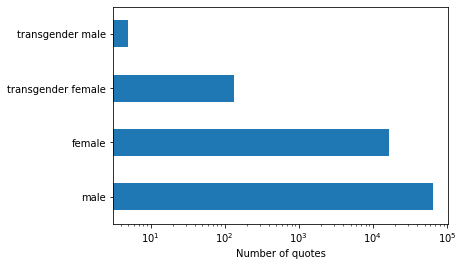

In [ ]:
pd.merge(df_speakerinfo.gender.str[0].to_frame(), readable, right_on = "QID", left_on = "gender").Label.value_counts().plot.barh()
plt.xscale("log")
plt.xlabel("Number of quotes")
plt.show()

We want to get an idea about the frequency of quotations divided by the political party of its speaker. To get just a rough idea of this distribution we plot it considering just the first party in the party list of each politician, even if we are aware that this not always corresponds to the last party they were into.

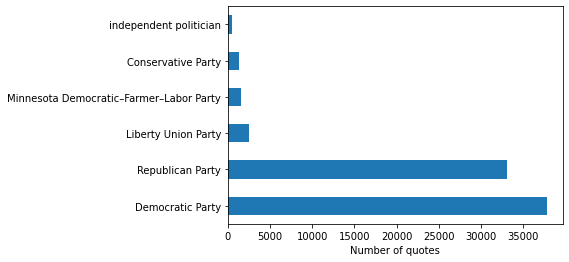

In [ ]:
pd.merge(df_speakerinfo.party.str[0].to_frame(), readable, right_on = "QID", left_on = "party").Label.value_counts()[:6].plot.barh()
plt.xlabel("Number of quotes")
plt.show()

We can also choose some of the most popular politicans from both major parties and we take a look at how many quotes they have in the dataset since we will be interested also in the comparison beteen just two (or few) opposite politicians.

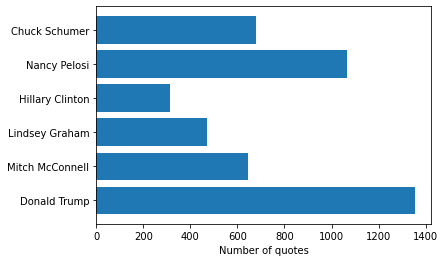

In [ ]:
politicians = ["Donald Trump", "Mitch McConnell", "Lindsey Graham", "Hillary Clinton", "Nancy Pelosi", "Chuck Schumer"]
n_quotes = []
for politician in politicians:
  n_quotes.append(len(df.loc[df.speaker == politician]))
plt.barh(politicians, n_quotes)
plt.xlabel("Number of quotes")
plt.show()

Now we can start trying to use the NLTK library to tokenize the quotations and proceed with the analysis.

We firstly want to stem the all the words, in order to avoid double counting of words such as "graduation", "graduate" and "graduated". Then we also want to remove all the stopwords, for example "and", "a", "or".

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer, LancasterStemmer
import nltk
import string
from nltk.corpus import stopwords
from operator import itemgetter
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We create a `tokenize` function, which removes the punctuation, remove english stopwords and then apply the stemming.

In [ ]:
def tokenize(text, stemmer):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens if word not in stopwords.words('english')])

We can choose between different stemming methods, so we try the three most commonly used (Porter, Snowball and Lancaster) on five random quotations on the dataset to see practically how they differ one from each other.

In [ ]:
for i in range(5):
  print('quotation', i, ': ', df.iloc[i+100,1])

quotation 0 :  Regardless of what situation a mom presents herself in, (this program has the) connections across the community that you can actually show 15 years after the intervention. The little one is more likely to stay in high school, to get into the workforce and not be incarcerated.
quotation 1 :  Sanders is appealing to them and if that doesn't work for them, then the Trump team hopes they'll come their way.
quotation 2 :  She is in a bit of limbo at this point,
quotation 3 :  single-best tool to inform decisions.
quotation 4 :  So thank you to everybody who's doing what I'm doing, working from home to stop the spread of the virus from household to household. That's the way we're going to win. We're going to beat it and we're going to beat it together. Stay at home, protect the NHS, and save lives.


In [ ]:
# Porter Stemmer
stemmer_p = PorterStemmer()

for i in range(5):
  print('quotation', i, ': ', tokenize(df.iloc[i+100,1], stemmer_p))

quotation 0 :  regardless situat mom present program connect across commun actual show 15 year intervent the littl one like stay high school get workforc incarcer
quotation 1 :  sander appeal doesnt work trump team hope theyll come way
quotation 2 :  she bit limbo point
quotation 3 :  singlebest tool inform decis
quotation 4 :  so thank everybodi who im work home stop spread viru household household that way go win were go beat go beat togeth stay home protect nh save live


In [ ]:
# Snowball Stemmer
stemmer_s = SnowballStemmer('english')

for i in range(5):
  print('quotation', i, ': ', tokenize(df.iloc[i+100,1], stemmer_s))

quotation 0 :  regardless situat mom present program connect across communiti actual show 15 year intervent the littl one like stay high school get workforc incarcer
quotation 1 :  sander appeal doesnt work trump team hope theyll come way
quotation 2 :  she bit limbo point
quotation 3 :  singlebest tool inform decis
quotation 4 :  so thank everybodi whos im work home stop spread virus household household that way go win were go beat go beat togeth stay home protect nhs save live


In [ ]:
# Lancaster
stemmer_l = LancasterStemmer()

for i in range(5):
  print('quotation', i, ': ', tokenize(df.iloc[100+i,1], stemmer_l))

quotation 0 :  regardless situ mom pres program connect across commun act show 15 year interv the littl on lik stay high school get workforc incarc
quotation 1 :  sand ap doesnt work trump team hop theyl com way
quotation 2 :  she bit limbo point
quotation 3 :  singlebest tool inform decid
quotation 4 :  so thank everybody who im work hom stop spread vir household household that way going win wer going beat going beat togeth stay hom protect nhs sav liv


We clearly see that Porter and Snowball are similar to each other while Lancaster is way more aggressive. Between Porter and Snowball we choose the former one as, even if similar, we think that it is more appropriate for some types of words, as shown below:

In [ ]:
# Porter
print(stemmer_p.stem("generously"))

gener


In [ ]:
# Snowball
print(stemmer_s.stem("generously"))

generous


(End of Milestone 2)

# Integration of speakers' metadata from external datasets

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')
from pipeline import cleaning

years = [2015, 2016, 2017, 2018, 2019, 2020]
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet')
speaker_attributes.drop(['lastrevid', 'type', 'religion'], axis = 1, inplace = True)

cleaning(years, speaker_attributes)

The `cleaning` function we imported from the `pipeline.py` file stored in our Google Drive folder a cleaned dataset for each year. Then we merged them all toghether. Unfortunately due to the dataset size we were not able to save it all at once se we ended up creating two different datasets:
-  `final`: Which has the quotation, speaker and probabilities columns.
- `final2`: Which has the quotation, speaker and QIDs columns.

We will directly import these two datasets and use them without running again the code generating the dataset because of the long running time.

We restore the latest Pandas version after having downgraded it to read the quotebank dataset in chunks.
We also install openpyxl v. 3.0.5 that will be used later on.

In [ ]:
!pip install pandas==1.3.5
!pip install openpyxl==3.0.5

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

The goal of this section is to associate to each Senator or Congressman's metadata, their QID. We will use this association to draw intresting statistics about the language skills for particular groups of politicians.

We select the final version of the filtered Quotebank dataset which only includes quotes being attributed to less than 4 different QIDS, of which at least one correspond to an individual whose professions include "Politician" and whose nationality is American.

In [ ]:
filtered_quotebank = pd.read_csv('/content/drive/MyDrive/ADA project/final2.zip')

We create a new dataset called *x* to associate each list of qids left inside *filtered_quotebank* to all possible ways they are called inside quotebank (e.g. we associate Barack Obama's QID to *{'barack hussein obama', 'barack hussein obama ii', 'barack obama', 'barack obama ii', 'barak obama', 'barry obama', 'president barack obama', 'president obama'}* ).

In [ ]:
x = filtered_quotebank.groupby(["qids"])["speaker"].apply(';'.join).reset_index()

We then apply some transformation, such as lower casing all possible strings containing his name, stripping away blank spaces at the end and finally selecting unique strings.

In [ ]:
x["speaker"] = x["speaker"].str.lower()
x["speaker"] = x["speaker"].str.split(";")
x["speaker"] = x["speaker"].apply(lambda x: [s.strip() for s in x])
x["speaker"] = x["speaker"].apply(set)

We then transform the column containing the QIDs (which is string when it should be a list of QIDs) into an actual list of strings.

In [ ]:
import ast
x['qids'] = x.qids.apply(lambda x : ast.literal_eval(x))

In [ ]:
x.head()

,qids,speaker
0,[Q1001235],{buddy leach}
1,"[Q1002293, Q30015838]",{dustin johnson}
2,"[Q100446, Q4759824]","{andré bauer, andre bauer}"
3,[Q1017083],{burt l. talcott}
4,[Q1018322],{donald lukens}


The next step is to associate all possible ways a speaker is named in the dataset to the unique QID of that person. In particular we select the names associated to only one QID since we are sure they belong to a politician of American nationality.

Then, we merge them with the corresponding names associated with rows of multiple QIDs of which at least one coincide with the single one. This is done to include the widest selection of ways each individual is named. 


In [ ]:
x_singleid = x.loc[x.qids.apply(lambda x: len(x))==1]
x_singleid.qids = x_singleid.qids.apply(lambda x: x[0])

We create an additional variable to later check that the union adds name strings to the sets of names linked to each QID

In [ ]:
x_singleid['count'] = x_singleid.speaker.apply(lambda x: len(x))

At this point we select all rows where the list of QIDs is composed either by 2 or 3 elements. And we explode the rows, in order to merge them with the *x_singleid* dataset to group all possible names associated with each American politician's QID.

In [ ]:
x_2id = x.loc[x.qids.apply(lambda x: len(x)) == 2]
x_2id = x_2id.explode('qids')
x_2id = x_2id.rename(columns={'speaker':'speaker_s','qids':'qids_s'})

x_3id = x.loc[x.qids.apply(lambda x: len(x)) == 3]
x_3id = x_3id.explode('qids')
x_3id = x_3id.rename(columns={'speaker':'speaker_s','qids':'qids_s'})

We first perform the merge with *x_2id* and unite the set of names' strings

In [ ]:
x_singleid = x_singleid.merge(x_2id, how='left', left_on='qids', right_on='qids_s')
x_singleid.speaker_s.loc[x_singleid.speaker_s.isnull()] = x_singleid.speaker_s.loc[x_singleid.speaker_s.isnull()].apply(lambda x: {})
x_singleid['speaker'] = x_singleid.apply(lambda x: x['speaker'].union(x['speaker_s']), axis=1)

We now check that this passage was actually useful, meaning that we added some strings to the set of all names associated to each QID. We later performed the same test for *x_3id* but we don't show it here to avoid verbosity.

In [ ]:
x_singleid['count_after'] = x_singleid.speaker.apply(lambda x: len(x))
x_singleid['count_diff'] = x_singleid['count_after'] - x_singleid['count']

x_singleid.sort_values(by='count_diff',ascending=False).head()

,qids,speaker,count,qids_s,speaker_s,count_after,count_diff
4184,Q207,"{bush 43, bush jr. ., bush , george w., george...",6,Q207,"{george bush, president bush}",8,2
5046,Q3218882,"{larry fink, laurence fink, laurence douglas f...",2,Q3218882,"{larry fink, laurence fink}",4,2
6804,Q5076629,"{charles d. baker, governor charlie baker, cha...",2,Q5076629,"{charles d. baker, charles duane baker}",4,2
4474,Q23505,"{george herbert bush, g.h.w. bush, george h. w...",30,Q23505,"{george bush, president bush}",32,2
12030,Q7325383,"{richard e. jackson, richard joseph jackson}",1,Q7325383,{richard joseph jackson},2,1
...,...,...,...,...,...,...,...
4697,Q27063675,{cloria brown},1,NaN,{},1,0
4698,Q27063680,{john pridnia},1,NaN,{},1,0
4699,Q27087919,{don phillips},1,NaN,{},1,0
4700,Q271061,{olene s. walker},1,NaN,{},1,0


We now perform the same merge as above with *x_3id* and unite once again the set of names' strings

In [ ]:
x_singleid = x_singleid[['qids','speaker']]
x_singleid = x_singleid.merge(x_2id, how='left', left_on='qids', right_on='qids_s')
x_singleid.speaker_s.loc[x_singleid.speaker_s.isnull()] = x_singleid.speaker_s.loc[x_singleid.speaker_s.isnull()].apply(lambda x: {})
x_singleid['speaker'] = x_singleid.apply(lambda x: x['speaker'].union(x['speaker_s']), axis=1)
x_singleid = x_singleid[['qids','speaker']]

We noticed that in the `speakers_attributes` dataset there are often many parties associated to each politician and they do not follow a precise ordering. Hence, we decided to integrate this information, with also some other demographical features, from external sources.
In particular we import two datasets (Voteview and the Biographical Directory of the US Congress) which we need in order to attribute to all Congressmen and/or Senators having quotes in Quotebank features such as: birth year, party affiliation, State of election, District code, Chamber of which they were member etc...

In [ ]:
congress = pd.read_csv('/content/drive/MyDrive/search.csv')
voteview = pd.read_csv('/content/drive/MyDrive/HSall_members.csv')

voteview = voteview.drop(['nominate_dim1', 'nominate_dim2',
       'nominate_log_likelihood', 'nominate_geo_mean_probability',
       'nominate_number_of_votes', 'nominate_number_of_errors', 'conditional',
       'nokken_poole_dim1', 'nokken_poole_dim2'],axis=1)
congress = congress.drop(['birthYear', 'deathYear', 'congresses','honorificTitle','honorificPrefix'],axis=1)

In [ ]:
congress.head()

,id,givenName,familyName,middleName,unaccentedGivenName,unaccentedFamilyName,unaccentedMiddleName,nickName,honorificSuffix
0,H000067,Ralph,Hall,Moody,Ralph,Hall,Moody,NaN,NaN
1,L000123,Frank,Lautenberg,Raleigh,Frank,Lautenberg,Raleigh,NaN,NaN
2,D000355,John,Dingell,David,John,Dingell,David,NaN,Jr.
3,C000714,John,Conyers,NaN,John,Conyers,NaN,NaN,Jr.
4,S000480,Louise,Slaughter,McIntosh,Louise,Slaughter,McIntosh,NaN,NaN


In [ ]:
voteview.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,bioguide_id,born,died
0,1,President,99869,99,0.0,USA,5000,NaN,NaN,"WASHINGTON, George",NaN,NaN,NaN
1,1,House,4766,1,98.0,CT,5000,0.0,1.0,"HUNTINGTON, Benjamin",H000995,1736.0,1800.0
2,1,House,8457,1,98.0,CT,5000,0.0,1.0,"SHERMAN, Roger",S000349,1721.0,1793.0
3,1,House,9062,1,98.0,CT,5000,0.0,1.0,"STURGES, Jonathan",S001047,1740.0,1819.0
4,1,House,9489,1,98.0,CT,5000,0.0,1.0,"TRUMBULL, Jonathan, Jr.",T000389,1740.0,1809.0


In the next step we merge the two datasets since Voteview contains the features we are intrested in but features politician names' strings which are not atomized, differently from the Biographical Directory of the US Congress. We merge them on a unique key called *id* which is consistent among the two datasets.

In [ ]:
df_merge = voteview.merge(congress, how='left', left_on='bioguide_id', right_on='id').drop(['last_means','icpsr','id'],axis=1)

We then select members of the congresses corresponding to the years of quotes included in Quotebank, from the 114th (2015-2017) until the 116th (2019-2021). Clearly we are assuming that the majority of quotes in quotebank are published in the same years in which they have been said.

In [ ]:
df_merge = df_merge.loc[df_merge.congress > 113].loc[df_merge.congress < 117]

In [ ]:
df_merge.head()

,congress,chamber,state_icpsr,district_code,state_abbrev,party_code,occupancy,bioname,bioguide_id,born,died,givenName,familyName,middleName,unaccentedGivenName,unaccentedFamilyName,unaccentedMiddleName,nickName,honorificSuffix
47739,114,President,99,0.0,USA,100,0.0,"OBAMA, Barack",O000167,1961.0,NaN,Barack,Obama,NaN,Barack,Obama,NaN,NaN,NaN
47740,114,House,41,3.0,AL,200,0.0,"ROGERS, Mike Dennis",R000575,1958.0,NaN,Michael,Rogers,Dennis,Michael,Rogers,Dennis,NaN,NaN
47741,114,House,41,7.0,AL,100,0.0,"SEWELL, Terri",S001185,1965.0,NaN,Terri,Sewell,NaN,Terri,Sewell,NaN,NaN,NaN
47742,114,House,41,2.0,AL,200,0.0,"ROBY, Martha",R000591,1976.0,NaN,Martha,Roby,NaN,Martha,Roby,NaN,NaN,NaN
47743,114,House,41,5.0,AL,200,0.0,"BROOKS, Mo",B001274,1954.0,NaN,Mo,Brooks,NaN,Mo,Brooks,NaN,NaN,NaN


Using the atomized names of the Biographical Directory dataset, for each politician we create 10 different strings with their name, to include the highest number of possible ways their name could have been written in the speaker attribute of wikidata.

In [ ]:
df_merge[['givenName', 'familyName', 'middleName', 'unaccentedGivenName',
       'unaccentedFamilyName', 'unaccentedMiddleName', 'nickName','honorificSuffix']] = df_merge[['givenName', 'familyName', 'middleName', 'unaccentedGivenName',
                                                                                                  'unaccentedFamilyName', 'unaccentedMiddleName', 'nickName','honorificSuffix']].fillna('')

df_merge['name_search_1'] = df_merge['givenName'] + ' ' + df_merge['middleName'] + ' ' + df_merge['familyName'] + ' ' + df_merge['honorificSuffix']
df_merge['name_search_2'] = df_merge['givenName'] + ' ' + df_merge['middleName'] + ' ' + df_merge['familyName']
df_merge['name_search_3'] = df_merge['givenName'] + ' ' + df_merge['familyName']
df_merge['name_search_4'] = df_merge['nickName'] + ' ' + df_merge['familyName']
df_merge['name_search_5'] = df_merge['unaccentedGivenName'] + ' ' + df_merge['unaccentedMiddleName'] + ' ' + df_merge['unaccentedFamilyName'] + ' ' + df_merge['honorificSuffix']
df_merge['name_search_6'] = df_merge['unaccentedGivenName'] + ' ' + df_merge['unaccentedMiddleName'] + ' ' + df_merge['unaccentedFamilyName']
df_merge['name_search_7'] = df_merge['unaccentedGivenName'] + ' ' + df_merge['familyName']
df_merge['name_search_8'] = df_merge['familyName'] + ' ' + df_merge['givenName']
df_merge['name_search_9'] = df_merge['familyName'] + ' ' + df_merge['unaccentedGivenName']
df_merge['name_search_10'] = df_merge['familyName'] + ' ' + df_merge['nickName']

namesearch_col_names = ['name_search_1','name_search_2','name_search_3','name_search_4','name_search_5',
          'name_search_6','name_search_7','name_search_8','name_search_9','name_search_10']

df_merge[namesearch_col_names] = df_merge[namesearch_col_names].apply(lambda x: x.astype(str).str.lower())

In [ ]:
df_merge.head()[namesearch_col_names]

,name_search_1,name_search_2,name_search_3,name_search_4,name_search_5,name_search_6,name_search_7,name_search_8,name_search_9,name_search_10
47739,barack obama,barack obama,barack obama,obama,barack obama,barack obama,barack obama,obama barack,obama barack,obama
47740,michael dennis rogers,michael dennis rogers,michael rogers,rogers,michael dennis rogers,michael dennis rogers,michael rogers,rogers michael,rogers michael,rogers
47741,terri sewell,terri sewell,terri sewell,sewell,terri sewell,terri sewell,terri sewell,sewell terri,sewell terri,sewell
47742,martha roby,martha roby,martha roby,roby,martha roby,martha roby,martha roby,roby martha,roby martha,roby
47743,mo brooks,mo brooks,mo brooks,brooks,mo brooks,mo brooks,mo brooks,brooks mo,brooks mo,brooks


We then create an exploded copy of the *x_final* dataset. The resulting dataset is a dataset where each QID is matched with every possible name of the politician.

In [ ]:
x_exploded = x_singleid.copy()
x_exploded['speaker'] = x_exploded.speaker.apply(list)
x_exploded = x_exploded.explode('speaker')
x_exploded.head()

,qids,speaker
0,Q1001235,buddy leach
1,Q1017083,burt l. talcott
2,Q1018322,donald lukens
3,Q1026119,cal dooley
4,Q1027431,tim wirth


Next, using a merge on the newly created columns with the different combination of names' strings, we associate to each Senator or Congressman his/her QID taken from Quotebank

In [ ]:
qids_col_names = ['qids_1','qids_2','qids_3','qids_4','qids_5','qids_6','qids_7','qids_8','qids_9','qids_10']

for i in range(len(qids_col_names)):
  x_exploded = x_exploded.rename(columns = {'speaker':'speaker', 'qids': qids_col_names[i] })
  df_merge = df_merge.merge(x_exploded, how='left', left_on= namesearch_col_names[i], right_on='speaker').drop(['speaker'],axis=1)
  x_exploded = x_exploded.rename(columns = {'speaker':'speaker', qids_col_names[i]:'qids'})

In [ ]:
# This dataset will be useful later
qid_names = x_exploded.copy()
qid_names.to_csv('/content/drive/MyDrive/ADA project/qid_names.csv')

We check whose Senator/Congressman's QID is missing and we create an excel file, with around 200 names, to be hand filled with the corresponding QID codes. 

In [ ]:
df_merge['is_na'] = df_merge[qids_col_names].isnull().apply(lambda x: all(x), axis=1) 
missing = df_merge.loc[df_merge.is_na == True].bioname.unique()
pd.DataFrame(data=missing, columns=["bionames"]).to_excel('/content/drive/MyDrive/Colab Notebooks/Unmatched.xlsx')

We then merged the QIDs taken from the hand filled document with data of Senators and Congressmen from *df_merge*. Here below we include some additional steps to verify that Quotebank actually included at least one quote from each Senator or Congressman whose QID was included in the hand-filled document.  

In [ ]:
unmatched = pd.read_excel('/content/drive/MyDrive/ADA project/Unmatched_FILLED.xlsx')

missing_df = pd.DataFrame(data=x_singleid.copy().qids.unique(), columns=["qids"])
missing_sen = unmatched.merge(missing_df, how = 'left', left_on='qids_unmatched', right_on = 'qids')
fill_sen = missing_sen.loc[~missing_sen.qids.isna()][['bioname','qids_unmatched']]
df_merge = df_merge.merge(fill_sen, how='left', on='bioname')

We finally join together all the qids found through the various merges, we put them together in a set and verify for each senator not more than one was found. We finally extract the unique value from the set and remove the columns we are not intrested in. 

In [ ]:
df_merge['QIDS'] = df_merge[['qids_1','qids_2','qids_3','qids_4','qids_5','qids_6','qids_7','qids_8','qids_9','qids_10','qids_unmatched']].values.tolist()
df_merge['QIDS'] = df_merge.QIDS.apply(lambda x: set(x))
df_merge['QIDS'] = df_merge.QIDS.apply(lambda x: list(x))
df_merge['QIDS'] = df_merge.QIDS.apply(lambda x: [el for el in x if str(el) != 'nan'])
df_merge['count_QIDS'] = df_merge.QIDS.apply(lambda x: len(x)) #to check nobody had more than one QID
df_merge = df_merge.loc[df_merge.count_QIDS > 0]
df_merge['QIDS+'] = df_merge.QIDS.apply(lambda x: x[-1])
df_merge = df_merge.rename(columns={'QIDS+':'QID'})
df_merge = df_merge[['congress','chamber','state_icpsr','district_code','state_abbrev','party_code','occupancy','bioname','bioguide_id','born','died','QID']]

In [ ]:
df_merge.head()

,congress,chamber,state_icpsr,district_code,state_abbrev,party_code,occupancy,bioname,bioguide_id,born,died,QID
0,114,President,99,0.0,USA,100,0.0,"OBAMA, Barack",O000167,1961.0,NaN,Q76
1,114,House,41,3.0,AL,200,0.0,"ROGERS, Mike Dennis",R000575,1958.0,NaN,Q693238
2,114,House,41,7.0,AL,100,0.0,"SEWELL, Terri",S001185,1965.0,NaN,Q461621
3,114,House,41,2.0,AL,200,0.0,"ROBY, Martha",R000591,1976.0,NaN,Q439117
4,114,House,41,5.0,AL,200,0.0,"BROOKS, Mo",B001274,1954.0,NaN,Q1941306


In [ ]:
df_merge.sort_values(by='bioname').to_excel('/content/drive/MyDrive/Colab Notebooks/congressmembers_senators_MULTI.xlsx')

We drop Obama as during the considered congresses he was not either a Senator or a Congressman. In addition being the president he did not represent any particular state. So we shall not include him in the general statistics created below.

In [ ]:
df_merge = df_merge.loc[~(df_merge.QID == 'Q76')]

We finally export a version of this dataset where we keep data regarding each Senator and Congressman, taking into account only the first mandate but each of them. Since we verified the cases where a Senator or Congressman has switched party are just 2 and there are none who changed State of election. 

In [ ]:
congress = df_merge.sort_values(by='congress', ascending=True).drop_duplicates(subset=['bioguide_id'], keep='first')
congress.to_csv("/content/drive/MyDrive/ADA project/congressmembers_senators_unique.csv")

In [ ]:
congress.head()

,congress,chamber,state_icpsr,district_code,state_abbrev,party_code,occupancy,bioname,bioguide_id,born,died,QID
1,114,House,41,3.0,AL,200,0.0,"ROGERS, Mike Dennis",R000575,1958.0,NaN,Q693238
382,114,House,49,22.0,TX,200,0.0,"OLSON, Pete",O000168,1962.0,NaN,Q2073303
381,114,House,49,28.0,TX,100,0.0,"CUELLAR, Henry",C001063,1955.0,NaN,Q539562
380,114,House,49,24.0,TX,200,0.0,"MARCHANT, Kenny",M001158,1951.0,NaN,Q368184
379,114,House,49,11.0,TX,200,0.0,"CONAWAY, K. Michael",C001062,1948.0,NaN,Q538944


# Creation of the statistics

We start by importing the dataset version with qids column, then we do some minor modification to it and to the congress members dataset that we prepared, then proceed with the merge of the two (in order to have the politicians' metadata together with the quotes).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ADA project/final2.zip')

In [ ]:
congress.rename(columns={'QID' : 'qids'}, inplace=True)

We convert the qids column to a list, while corrently it is a string containing a list of strings (the qids)

In [ ]:
import ast
df['qids'] = df.qids.apply(lambda x : ast.literal_eval(x))

Here we decide to drop all the quotations which have in the qids column more than one qid. We decided to do so after having checked that in this way, the number of quotations lost is not significant. This way we solve the problem of homonyms in a quick way.

In [ ]:
# mask to find those politicians with just one qid
mask = df['qids'].apply(lambda x: len(x) < 2)

In [ ]:
df_congress = df[mask]

We convert the lists of single qids to strings.

In [ ]:
df_congress['qids'] = df_congress.qids.apply(lambda x: x[0])

Finally we merge the two datasets and we have our congress members dataset with quotations ready.

In [ ]:
df_congress.drop(['Unnamed: 0'], axis = 1, inplace=True)
df_congress = df_congress.merge(congress['qids'], on='qids')
df_congress.head()

,quotation,speaker,qids
0,... a great day for veterans here in Littleton...,Jeanne Shaheen,Q270316
1,The safety and security of our nation is at ri...,Jeanne Shaheen,Q270316
2,It's been my experience that the faith communi...,Jeanne Shaheen,Q270316
3,we need to bring the parents in so they can se...,Jeanne Shaheen,Q270316
4,"Listen, a month ago people were saying Hillary...",Jeanne Shaheen,Q270316


We now keep only the politicians with more than 100 quotations, because otherwise the metrics we will use would not be robust. Once again, we checked that the data loss is not significant.

In [ ]:
x = df_congress.groupby('qids').count()['quotation'] > 100
qids_list = x[x].index
df_congress = df_congress[df_congress['qids'].isin(qids_list)]

Now with the datsets created we can proceed with our goal of analyzing the communication styles of different politicians.

Before starting we create a function which for a given name returns the qids corresponding to that politician, so that searching by qid we avoid problems of multiple nicknames.

In [ ]:
qids_names = pd.read_csv('/content/drive/MyDrive/qid_names.csv') #This dataset was created and exported in the previous section

def get_qid(name):
  return qids_names.loc[qids_names['speaker']==name]['qids'].iloc[0]

In [ ]:
get_qid('donald trump')

'Q22686'

In [ ]:
get_qid('president donald trump')

'Q22686'

We also implement the opposite version, which from the qids returns the first name in the list, which will be useful later on.

In [ ]:
def get_name(qid):
  return qids_names.loc[qids_names['qids']==qid]['speaker'].iloc[0]

To analyze the lexical level of politicians, we will use two groups of metrics: some will be computed thanks to an API, some other will be computed using formulae implemented in our functions. 

## Metrics using API

We will use the [API "Textinspector"](https://textinspector.com/), which is widely used to evaluate some readability and diversity metrics on texts. The metrics we will be taking from the API are the following:
1. Flesch reading-ease: The Flesch reading-ease index is a measure for the “readability” of a text. The higher the score, the “simpler” the text, and the easier it is to read. (Hence, in our analysis, a high score indicates that the politician has a very simple language. It can be correlated either with a lack of education or with a willingness to be understood by everybody!).

2. Flesch-Kincaid Grade: The Flesch-Kincaid Grade is a modification of the Flesch Reading Ease index, and has a nice straightforward interpretation: its output represents roughly the number of years of education required to understand the text provided. The formula for the grade is the following:

3. Gunning Fog Index: The Gunning Fog index is yet another readability score. Very closely to the Flesch-Kincaid Grade, it tries to make an estimate of the number of years of formal education needed to understand the text when reading it for the first time. The formula for the Gunning fox index is the following, where “complex words” are defined as the words with 3 or more syllables. 

4. MTLD and VOC-d: The MTLD and the VOC-d measures are lexical diversity measures. The idea behind both metrics is to leverage the Type-to-Token ratio (TTR), defined as the ratio between the types (the total number of different words) occurring in a text by its tokens (the total number of words).


We used the API just on a small subset of politicians, since in the free plan we had just a limited number of API calls. 

In [ ]:
#Initiating the session
r = requests.get('https://robi.ceraolo@gmail.com:Xihco9-dirjar-musqer@textinspector.com/api/v2/createsession')
session_id = r.json()["sessionid"]

In [ ]:
#Auxiliary functions
import unicodedata

def prettify_scorecard(response):
  """
  Transforms the output of the API in a humanly readable fashion. This one works with "scorecardrating" metric
  """
  new_dict = {}
  for ind in response["response"]:
    if ind == "overallRating":
      new_dict = response["response"][ind]
  new_dict.pop('friendlyName', None)
  return new_dict



def prettify(response):
  """
  Transforms the output of the API in a humanly readable fashion. This one works with "statistics", "errors", "diversity" metrics
  """
  new_dict = {}
  for ind in response["response"]:
    if ind!="ctxId" or ind !="documentId": 
      if type(response["response"][ind]) != dict:
          continue
      for i in response["response"][ind]:
        if type(response["response"][ind][i]) != dict:
          continue
        key = response["response"][ind][i]["friendlyName"]
        value = response["response"][ind][i]["value"]
        new_dict[key] = value
  return new_dict


def strip_accents(text):
  """
  Function to remove characters with accents
  """
  try:
      text = unicode(text, 'utf-8')
  except NameError:
      pass

  text = unicodedata.normalize('NFD', text)\
          .encode('ascii', 'ignore')\
          .decode("utf-8")

  return str(text)

In [ ]:
#API call

def call_api(text, sessionid = session_id, metric= "statistics", prettify_bool = True):
  """
  Function that calls the API of textinspector with our credentials. Given a text, it returns many statistics about its readibility
  and lexical complexity. 
  Possible values for the metric:
  statistics and readability
  errors (not very useful as they may be errors of the journalists)
  diversity: MLTD e VOCD
  scorecardrating: CEFR Level of English
  and others, which are not included here.
  """

  if type(text)!=str:
    raise Exception("Not a valid input")

  text =  text.replace(" ", "+")

  cookies = {
      'textinspector.session': sessionid,
  }

  headers = {
      'Content-Type': 'application/json',
      'accept': 'application/json',
  }

  data = '{"text":"' + text +'"}'

  response = requests.post('https://textinspector.com/api/v2/newanalysis', headers=headers, cookies=cookies, data=data)
  ctxId = response.json()["response"]["ctxId"]
  
  #we use number of documents = 1
  headers = {
      'accept': 'application/json',
  }

  link = 'https://textinspector.com/api/v2/' + ctxId + '/doc1/' + metric

  response = requests.get(link, headers=headers, cookies=cookies)
  #response.encoding = 'latin-1'
  if prettify_bool:
    if metric == "scorecardrating":
      return prettify_scorecard(response.json())
    else:
      return prettify(response.json())
  return response.json()




In [ ]:
#Extracting statistics for a politician
def extract_statistics(politician, metric = "statistics", num_chars = 20000, seed_=42, p_cutoff=0.9, dataset = df):
  """
  Function that takes only the quotes with the speaker label given with high confidence, then samples 10000
  quotes, aggregates all the quotes in a unique text, cleans it, cuts it to its first "num_chars" characters
  and finally calls the API with "metric" on the text.
  """
  qid = get_qid(politician)
  if 'probas' in dataset.columns: 
    dataset_politician = dataset[dataset.probas > p_cutoff][dataset[dataset.probas > p_cutoff]["qids"]==qids] #only high confidence labels
  else:
    dataset_politician = dataset[dataset["qids"]==qid] #normal version
  dataset_politician.reset_index(inplace=True, drop=True)
  n = len(dataset_politician)
  inds_shuffled = np.arange(n)
  np.random.seed(seed_)
  np.random.shuffle(inds_shuffled)
  num_quotes = 2000 if n>2000 else n
  print(f"Number of quotes taken: {num_quotes}")
  inds_shuffled = inds_shuffled[:num_quotes]
  text_politician = dataset_politician.loc[inds_shuffled].groupby(['qids'], as_index = False).agg({'quotation': ' '.join})["quotation"]
  text_politician = text_politician[0]
  accepted_chars = [",", ".", ":", ";", " ", "'", "-"]
  text_politician = ''.join(char for char in text_politician if char.isalnum() or char in accepted_chars)
  text_politician = strip_accents(text_politician)
  if num_chars > 80000:
    print("Excessive number of characters, it is set automatically to 80000") #MAX 80000
    num_chars = 80000
  num_chars = len(text_politician) if len(text_politician)<num_chars else num_chars
  print(f"Number of characters taken: {num_chars}")
  return call_api(text_politician[:num_chars], metric= metric, prettify_bool=True), qid


In [ ]:
#Extracting and averaging statistics for a given politician
def overview_politician(politician, dataset = df):
  """
  This function provides a lexical overview for a politician. It computes:
  1. Flesh Reading Ease
  2. Flesch-Kincaid Grade
  3. Gunning Fog index
  4. MTLD Lexical Diversity
  5. VOCD Lexical Diversity
  6. CEFR Level
  All the metrics 1 to 3 are computed on samples of 20.000 characters, taken from 10.000 quotes chosen randomly, values are averaged over several runs
  Metrics 4 and 5 are computed with 5000 chars
  Metric 6 with 20000 chars, not averaged, as 20000 characters are a sufficient sample (around 6000 words)
  Only quotes with speaker assigned with probability higher than 0.8 are kept.
  """
  seeds = [45, 3134, 1245, 3521, 31345]
  #seeds = [42]
  fr = []
  fk = []
  gf = []
  vocds = []
  mtlds = []
  for ind, seed_ in enumerate(seeds):
    print(f"Run {ind}")
    resp_stats, qid = extract_statistics(politician, metric="statistics", num_chars=20000, seed_=seed_, dataset=dataset)
    if 'Flesch Reading Ease' in resp_stats.keys():
      curr_fr = float(resp_stats['Flesch Reading Ease'])
    else:
      curr_fr = np.nan
      break
    if 'Flesch-Kincaid Grade' in resp_stats.keys():
      curr_fk =float(resp_stats['Flesch-Kincaid Grade'])
    else:
      curr_fk = np.nan
      break
    if 'Gunning Fog index' in resp_stats.keys():
      curr_gf =float(resp_stats['Gunning Fog index'])
    else:
      curr_gf = np.nan
      break
    fr.append(curr_fr)
    fk.append(curr_fk)
    gf.append(curr_gf)
    print("Statistics done")
    resp_div, _ = extract_statistics(politician, metric="diversity", num_chars=5000, seed_=seed_, dataset=dataset)
    if 'VOCD Lexical Diversity' in resp_div.keys():
      vocds.append(float(resp_div['VOCD Lexical Diversity']))
    if 'MTLD Lexical Diversity' in resp_div.keys():
      mtlds.append(float(resp_div['MTLD Lexical Diversity']))
    print("Diversity done")
  resp_score, _ = extract_statistics(politician, metric="scorecardrating", num_chars=20000, seed_=seed_, dataset=dataset)#20000
  print("Scorecardrating done \n")
  mean_fr = np.round(np.mean(fr), 3)
  mean_fk = np.round(np.mean(fk), 3)
  mean_gf = np.round(np.mean(gf), 3)
  mean_vocd = np.round(np.mean(vocds), 3)
  mean_mtld = np.round(np.mean(mtlds), 3)
  print("Readibility scores")
  std_fr =np.round(np.std(fr), 3)
  std_fk = np.round(np.std(fk), 3)
  std_gf =np.round(np.std(gf), 3)
  std_vocd =np.round(np.std(vocds), 3)
  std_mtld =np.round(np.std(mtlds), 3)


  print(f"Mean Flesh Reading Ease: {mean_fr}, standard deviation: {std_fr}")
  print(f"Mean Flesch-Kincaid Grade: {mean_fk}, standard deviation: {std_fk}")
  print(f"Mean Gunning Fog index: {mean_gf}, standard deviation: {std_gf}\n")
  print("Diversity scores")
  print(f"Mean VOCD Lexical Diversity: {mean_vocd}, standard deviation: {std_vocd}")
  print(f"Mean MTLD Lexical Diversity: {mean_mtld}, standard deviation: {std_mtld}\n")
  print("CEFR score")
  if"cefrLevel" in resp_score.keys():
    level, num_metrics, perc = resp_score["cefrLevel"], resp_score["numberOfMetricsUsed"], resp_score["percentage"]
  else:
     level, num_metrics, perc = np.nan, np.nan, np.nan
  print(f"CEFR level: {level}")
  print(f"Number of metrics used: {num_metrics}")
  print(f"Percentage with respect to perfect native-speaker (100%): {perc}")

  return qid, mean_fr, std_fr, mean_fk, std_fk, mean_gf, std_gf, mean_vocd, std_vocd, mean_mtld, std_mtld, level, num_metrics, perc

## Metrics without API

Here we compute manually the Flesch reading Ease, Flesch–Kincaid readability test and the Gunning-Fog index, by following the relevant formulae for the metrics. 
Before that, we need a function able to count the syllables for each word (taken from StackExchange)

In [ ]:
import re

VOWEL_RUNS = re.compile("[aeiouy]+", flags=re.I)
EXCEPTIONS = re.compile(
    # fixes trailing e issues:
    # smite, scared
    "[^aeiou]e[sd]?$|"
    # fixes adverbs:
    # nicely
    + "[^e]ely$",
    flags=re.I
)
ADDITIONAL = re.compile(
    # fixes incorrect subtractions from exceptions:
    # smile, scarred, raises, fated
    "[^aeioulr][lr]e[sd]?$|[csgz]es$|[td]ed$|"
    # fixes miscellaneous issues:
    # flying, piano, video, prism, fire, evaluate
    + ".y[aeiou]|ia(?!n$)|eo|ism$|[^aeiou]ire$|[^gq]ua",
    flags=re.I
)

def count_syllables(word):
    vowel_runs = len(VOWEL_RUNS.findall(word))
    exceptions = len(EXCEPTIONS.findall(word))
    additional = len(ADDITIONAL.findall(word))
    return max(1, vowel_runs - exceptions + additional)

Now we can compute the above mentioned statistics. Each statistic is computed four times using each time a different subset of quotations, in this way we can assess the robustness of the metric and whether the metric is able to capture some person fixed effect or it is totally due to randomness.

In [ ]:
def readability(speaker, n_quotes = 500, dataset = df):
  qid = get_qid(speaker)
  quotes = dataset[dataset["qids"]==qid]
  quotes.reset_index(inplace=True, drop=True)
  if len(quotes) < n_quotes:
    print(f'Attention: you have less quotations than n_quotes, num of quotes automatically set to: {len(quotes)}')
    n_quotes = len(quotes)
  fre_list = []
  fgl_list = []
  gfi_list = []
  for i in range(4): # we calculate the metrcs 4 times and then take average and standard deviation to assess their robustness
    ind = np.random.permutation(len(quotes))[:n_quotes]
    text = quotes.loc[ind].groupby(['qids'], as_index = False).agg({'quotation': ' '.join})["quotation"][0]
    words = text.split()
    count_words = len(words)
    text_politician = text
    accepted_chars = [",", ".", ":", ";", " ", "'", "!", '?']
    text_politician = ''.join(char for char in text_politician if char.isalnum() or char in accepted_chars)
    text_politician = strip_accents(text_politician)
    count_sentences = len(nltk.sent_tokenize(text_politician))
    count_syll = 0
    syll = []
    count_complex = np.sum(np.array(syll) >= 3)
    for i in words:
      n_syll = count_syllables(i)
      count_syll += n_syll
      syll.append(n_syll)
    count_complex = np.sum(np.array(syll) >= 3)
    ratio0 = (count_words/count_sentences)
    ratio1 = (count_syll/count_words)
    ratio2 = (count_complex/count_words)
    fre = 206.835 - 1.015*ratio0 - 84.6*ratio1 #Flesch Reading Ease Formula
    fgl = 0.39*ratio0 + 11.8*ratio1 - 15.59 #Flesch Kincaid Grade Formula
    gfi = 0.4*(ratio0 + (100*ratio2)) #Gunning fog Index Formula
    fre_list.append(fre)
    fgl_list.append(fgl)
    gfi_list.append(gfi)
  return qid, np.round(np.mean(fre_list), 3), np.round(np.std(fre_list), 3), np.round(np.mean(fgl_list),3), np.round(np.std(fgl_list), 3), np.round(np.mean(gfi_list), 3), np.round(np.std(gfi_list), 3)

Here below we define three important metrics that we will use for the analyses:
- `frequency`: a function taking as argument a text (the union of some quotation), the stemmer to be used and the words window to look at. It returns the average number of different words used in the specified words window, a list of the counts of different words for each words window analyzed (it's the list on which we compute the mean and standard deviation), the standard deviation of such frequency, and the number of windows analyzed
- `metrics`: a function taking as argument a speaker, number of quotations to be used, stemmer and words window, and the dataset to use. It runs `frequency` over a random subset of quotation of the lenght and of the speaker specified.
- `most_freq_words`: a function taking as argument a speaker, a number of quotations to be used and a number of most frequently used words to retrieve. It returns a sorted list of the most used words and a variable to be used to make the Cloud representation of such words.
- `level_score`: Using an external dataset about the most frequent words in english, coming from many different sources (Academic, Web, BLOGS, TV, spoken language etc.) we were able to build a function which checks if each word is more used in spoken language or academic setting. It takes as argument a text and outputs the number of words which are more used in academic settings and the ones used more in spoken language.

In addition other two functions are defined, `tokenize` and `tokenize_stemm`. The former tokenizes the text passed as argument and removes the stopwords, the latter also performs stemming according to the specified stemmer.

In [ ]:
def tokenize(text): #Function already used in Milestone 2, reported again for clarity
    text = text.lower()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([word for word in tokens if word not in stopwords.words('english')])


def tokenize_stemm(text, stemmer):
    text = text.lower() # transorm the text into lowercase
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens if word not in stopwords.words('english')])


def frequency(text, stemmer, words_window):
  freq = []
  token = tokenize_stemm(text, stemmer)
  words = token.split()
  if len(words) < words_window:
    words_window = len(words)
    print(f"Window of words reduced to {words_window}")
    
  for i in range (words_window,len(words), words_window):
    current = words[i-words_window: i]
    n_words = len(Counter(current))
    freq.append(n_words)
  return np.mean(freq), freq, np.std(freq), len(freq), 1.96*np.std(freq)/np.sqrt(len(freq))


def metrics(speaker, n_quotes, stemmer, words_window, verbose = True, df = df):
  """
  Example of use:
  mean, freq, std, length = metrics('Joe Biden', 10000, stemmer, 10000)

  mean: mean of the number of unique words in subgroups of the quotes
  freq: list of number of occurrences
  length: number of subgroups


  """
  qid = get_qid(speaker)
  quotes = df[df["qids"]==qid]
  quotes.reset_index(inplace=True, drop=True)
  if len(quotes) < n_quotes:
    print(f'Attention: you have less quotations than {n_quotes}, num of quotes automatically set to: {len(quotes)}')
    n_quotes = len(quotes)
  ind = np.random.permutation(len(quotes))[:n_quotes]
  text = quotes.loc[ind].groupby(['qids'], as_index = False).agg({'quotation': ' '.join})["quotation"]
  mean, freq, std, length, ci = frequency(text[0], stemmer, words_window)
  if verbose:
    print(f'Number of quotes used: {n_quotes},\nMean of unique words: {np.round(mean, 3)},\nStandard Deviation: {np.round(std, 3)},\nNumber of subgroups of {words_window} words: {length}')
  return np.round(mean, 3), freq, np.round(std, 3), length, ci


def most_freq_words(speaker, n_quotes, top_words, df = df):
  """
  Example of use
  f, cloud = most_freq_words('Donald Trump', 1000, 250)

  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(cloud)
  plt.imshow(word_cloud, interpolation='bilinear')

  plt.axis("off")

  plt.show()

  top_words: how many top words you want

  """
  qid = get_qid(speaker)
  quotes = df[df["qids"]==qid]
  quotes.reset_index(inplace=True, drop=True)
  if len(quotes) < n_quotes:
    print(f'Attention: you have less quotations than n_quotes, num of quotes automatically set to: {len(quotes)}')
    n_quotes = len(quotes)
  ind = np.random.permutation(len(quotes))[:n_quotes]
  text = quotes.loc[ind].groupby(['qids'], as_index = False).agg({'quotation': ' '.join})["quotation"][0]
  text = tokenize(text)
  words = text.split()
  tagged = nltk.pos_tag(words)
  tagged_2 = list(zip(*tagged))
  # not_verbs = [tagged_2[0][i] for i in range(len(tagged)) if tagged_2[1][i] not in ['VB', 'VBD', 'VBP', 'VBG', 'VBN', 'VBZ']]
  not_verbs = [tagged_2[0][i] for i in range(len(tagged)) if tagged_2[1][i] in ['NN', 'NNP', 'NNPS', 'NNS']]
  counter = Counter(not_verbs)
  freq = dict( sorted(counter.items(), key=operator.itemgetter(1),reverse=True))
  most_freq = list(freq.keys())[:top_words]
  cloud = ' '.join(not_verbs)
  return most_freq, cloud


def level_score(quote, verbose=True):
  """
  Function that will provide us a score indicative of the level of 
  language used. In this version, it compares the words of the quote with the dataset from COCA
  and checks if each word is more used in spoken language or in academic setting.

  Example of use:
  level_score("Hypothesis testing is an act in statistics whereby an analyst tests an assumption regarding a population parameter")

  output:
  tuple (number of words more used in spoken language, number of words more used in academic language)
  """
  data_words = df_words_cut[df_words_cut.isin(quote).lemma==True].copy()
  data_words["spoken"] = data_words["spokPM"] > data_words["acadPM"]
  spoken_w = np.sum(data_words["spoken"])
  acad_w = len(data_words) - spoken_w
  for i in quote:
    output = "Spoken language" if data_words[data_words["lemma"]==i]["spoken"].all() else "Academic language"
    #if verbose:
    #  print(f"{i}: {output}")
    #  print("\n")
  if verbose:
    print(f"Count of spoken language words: {spoken_w}")
    print(f"Count of academic language words: {acad_w}")
  return spoken_w, acad_w


Here we deifne the stemmer that will be used in our analyses and we import the dataset used by the function `level_score`

In [ ]:
stemmer = PorterStemmer()
df_words = pd.read_excel('/content/drive/MyDrive/ADA project/wordFrequency.xlsx', sheet_name="1 lemmas")
df_words_cut = df_words[["lemma", "spokPM", "acadPM"]]
df_words_cut = df_words_cut.drop_duplicates(subset=['lemma'])

# Creation of the statistics' dataset

We define a function that generates a datasest using all the relevant metrics we defined above for a given list of politicians.
The columns that we create are the following: Flesch Reading Ease and its standard deviation, Flesch Kincaid grade and its standard deviation, Gunning Fog index and its standard deviation, number of unique words every 1000 words, number of words which are mostly used in spoken language, number of words which are mostly used in academic language.

When using the API, we also have MTLD and Voc-d with the respective standard deviations.

In [ ]:
def add_datapoints(politicians_list, statistics_df, dataset = df):

  for pol in politicians_list:
    print(f"Politician: {pol}")
    # res = overview_politician(pol, dataset=dataset)
    res = readability(pol, dataset = dataset)
    res = np.append(pol, np.array(res))
    print("\n")

    print("Non-API metrics")
    mean, _, std, _, _ = metrics(speaker = pol, stemmer = stemmer, n_quotes = 5000, words_window = 1000, verbose=True, df=dataset)
    res = np.append(res, np.array([mean,std]))
    print("\n")


    most_freq, _ = most_freq_words(pol, n_quotes = 1000, top_words = 300, df = dataset)

    spoken_w, acad_w = level_score(most_freq, True)
    res = np.append(res, np.array([spoken_w, acad_w]))

    res = pd.Series(data=res, index=cols_names)
    statistics_df = statistics_df.append(res, ignore_index=True)
    print(f"Politician {pol} added to dataset")
    print("\n")
  return statistics_df, res


In [ ]:
cols_names = ["Name","QID", "Flesh_Reading_Ease", "Flesh_Reading_Ease_std", "Flesch-Kincaid_Grade", "Flesch-Kincaid_Grade_std", "Gunning_Fog_index", "Gunning_Fog_index_std", "unique_words", "std_unique_words", "spoken_words", "acad_words"]
#unique_words: number of unique words for every 1000 words
#std_unique_words: std of the metric above
#spoken_words: number of spoken words, coming from the function level_score
#acad_words: number of academic words, coming from the function level_score

statistics_df = pd.DataFrame(columns=cols_names)


We now proceed with the creation of the metrics for the whole congress dataset using the previously defined function `add_datapoint`. Here we don't use the API since the high number of requests needed and the limited usage at our disposal.

In [ ]:
pols = [get_name(x) for x in df_congress.qids.unique()]

In [ ]:
statistics_df, res = add_datapoints(pols, statistics_df, df_congress) 

In [ ]:
statistics_df.to_csv(r'/content/drive/MyDrive/ADA project/statistics.csv', index = False)

We prepare also another dataset for some important names exploiting the API statistics. In this way the number of requests is small and under the limit we have been imposed by the API provider.
(To make it run, uncomment the lines referrred to the API in the `add_datapoints` function and comment the line referred to the `readibility` function).

In [ ]:
cols_names = ["Name","QID", "Flesh_Reading_Ease", "Flesh_Reading_Ease_std", "Flesch-Kincaid_Grade", "Flesch-Kincaid_Grade_std", "Gunning_Fog_index", "Gunning_Fog_index_std", "MTLD", "MTLD_std", "VOCD", "VOCD_std", "CEFR_level", "CEFR_num_metrics", "CEFR_percentage", "unique_words", "std_unique_words", "spoken_words", "acad_words"]

statistics_df = pd.DataFrame(columns=cols_names)

In [ ]:
important_names = ['donald trump', 'bernie sanders', 'hillary clinton', 'barack obama', 'ted cruz', 'joe biden', 'mike pence', 'marco rubio', 'ben carson', 'nancy pelosi']

In [ ]:
statistics_df, res = add_datapoints(important_names, statistics_df, df_congress) 

In [ ]:
statistics_df.to_csv(r'/content/drive/MyDrive/ADA project/important.csv', index = False)

# Add party information and proceed with the analysis

Now we can append to our lexical metrics also information about the political orientation and other demographic information to be able to perform all the aggregations and analyses we wanted to perform.

In [ ]:
statistics_df = pd.read_csv("/content/drive/MyDrive/ADA project/statistics.csv")

We convert all the numerical values to float type.

In [ ]:
numerical_cols = ['Flesh_Reading_Ease',
       'Flesh_Reading_Ease_std', 'Flesch-Kincaid_Grade',
       'Flesch-Kincaid_Grade_std', 'Gunning_Fog_index',
       'Gunning_Fog_index_std', 'unique_words', 'std_unique_words',
       'spoken_words', 'acad_words']
df_ttests = statistics_df.merge(congress, left_on='QID', right_on = 'qids')
df_ttests.drop('Unnamed: 0', axis = 1, inplace = True)
for i in numerical_cols:
  df_ttests[i] = df_ttests[i].astype(float)
df_ttests.head()

KeyError: ignored

# The last four presidential candidates

We are now interested into understanding whether there is any significant difference in any of the metrics we defined across the last four presidential candidates, Joe Biden, Donald Trump, Hillary Clinton and Barack Obama.
Since of these famous politicians we have many quotations, we restrict our attention to those with high probability of correct attribution (i.e. > 80%) to have a more precise analysis.

As already said, since for memory allocation problems it was not possible to save the dataset with both the qids and the probabilities columns, we created two identical versions of the dataset, one with the qid column, the other with the probabilties column. Now we need to import the and merge them in order to have both columns for the analysis.

In [ ]:
## keep just high probabilities
dataset = pd.read_csv("/content/drive/MyDrive/ADA project/final.zip")
dataset.drop("quoteID", axis = 1, inplace=True)
def extract_prob(x):
  try:
    x = float(x.split(",")[1][2:-2])
  except:
    x = np.nan
  return x

dataset["probas"] = dataset["probas"].apply(lambda x: extract_prob(x))
dataset.dropna(subset=['probas'], inplace=True)
df = dataset[dataset.probas > 0.80] 

In [ ]:
# import only the qids and speaker columns to merge the two datsets
qids = pd.read_csv('/content/drive/MyDrive/ADA project/final2.zip', usecols=['qids', 'speaker'])
import ast
qids['qids'] = qids.qids.apply(lambda x : ast.literal_eval(x))
mask = qids['qids'].apply(lambda x: len(x) < 2)
qids = qids[mask]
qids['qids'] = qids.qids.apply(lambda x: x[0])

In [ ]:
final = df.merge(qids, how='inner', left_on = df.index, right_on = qids.index, suffixes = ('', '_y'))
final.drop(['key_0', 'speaker_y'], axis = 1, inplace = True)
final.head()

,quotation,speaker,probas,qids
0,... we're hoping that he doesn't go for an agent.,Jim Schmitt,0.8396,Q2310157
1,"21st Century Workers Tax Cut Act,",Patty Murray,0.9460,Q258825
2,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,0.8848,Q1282411
3,a little more proof than usual,Jerome Powell,0.8498,Q6182718
4,I arrived on scene and observed a white male s...,Joe Rice,0.8754,Q6211995


We start by analyzing the number of unique words every 100, 200, 500, 1000, 2000, 5000 and 10000 words for each of the subjects. The number of quotations used is 5000 for each candidate.

In [ ]:
print(f"Trump\'s quotations: {len(final.loc[final['qids'] == get_qid('donald trump')])}")
print(f"Clinton\'s quotations: {len(final.loc[final['qids'] == get_qid('hillary clinton')])}")
print(f"Obama\'s quotations: {len(final.loc[final['qids'] == get_qid('barack obama')])}")
print(f"Biden\'s quotations: {len(final.loc[final['qids'] == get_qid('joe biden')])}")

Trump's quotations: 134506
Clinton's quotations: 28083
Obama's quotations: 59609
Biden's quotations: 17925


In [ ]:
np.random.seed(4)
Trump, Clinton, Obama, Biden = [], [], [], []
Trump_ci, Clinton_ci, Obama_ci, Biden_ci = [], [], [], []

Trump_std, Clinton_std, Obama_std, Biden_std = [], [], [], []
Trump_n, Clinton_n, Obama_n, Biden_n = [], [], [], []

windows = [100,200,500,1000,2000,5000,10000]
n_quotes = 5000

for i in windows:
  mean, _, std , n, ci = metrics('donald trump', n_quotes, stemmer, i, verbose = False, df = final)
  Trump.append(mean)
  Trump_ci.append(ci)
  Trump_std.append(std)
  Trump_n.append(n)
  mean, _, std, n, ci = metrics('hillary clinton', n_quotes, stemmer, i, verbose = False, df = final)
  Clinton.append(mean)
  Clinton_ci.append(ci)
  Clinton_std.append(std)
  Clinton_n.append(n)
  mean, _, std, n, ci = metrics('barack obama', n_quotes, stemmer, i, verbose = False, df = final)
  Obama.append(mean)
  Obama_ci.append(ci)
  Obama_std.append(std)
  Obama_n.append(n)
  mean, _, std, n, ci = metrics('joe biden', n_quotes, stemmer, i, verbose = False, df = final)
  Biden.append(mean)
  Biden_ci.append(ci)
  Biden_std.append(std)
  Biden_n.append(n)

We show a first plot of the results.

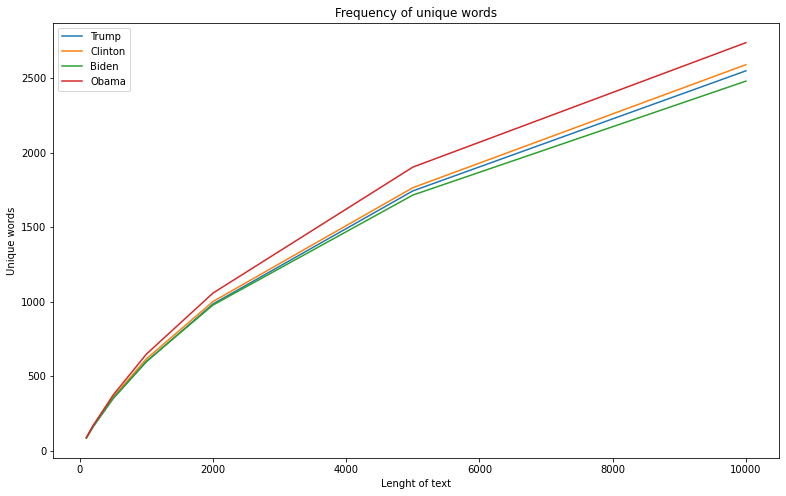

In [ ]:
plt.rcParams["figure.figsize"] = [13,8]
plt.plot(windows, Trump, label='Trump')
plt.plot(windows, Clinton, label = 'Clinton')
plt.plot(windows, Biden, label = 'Biden')
plt.plot(windows, Obama, label = 'Obama')
plt.title('Frequency of unique words')
plt.xlabel('Lenght of text')
plt.ylabel('Unique words')
plt.legend()
plt.show()

In order to see better the results we also show an interactive bar chart with confidence intervals.

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Create figure
fig = go.Figure() 

# Add traces, one for each slider step
for step in [0,1,2,3,4,5,6]:
    fig.add_trace(
        go.Bar(
            visible=False,
            name="𝜈 = " + str(windows[step]),
            x=['Trump', 'Clinton', 'Obama', 'Biden'],
            y=[Trump[step], Clinton[step], Obama[step], Biden[step]],
            error_y = {'array': np.array([Trump_ci[step], Clinton_ci[step], Obama_ci[step], Biden_ci[step]])},
            marker=dict(color = ['red', 'blue', 'green'],                 
                     colorscale='viridis')))      

fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        label = str(windows[i]),
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Different words each " + str(windows[i]) + " words."}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(yaxis_title="Numer of different words",
    sliders=sliders
)
fig.update_yaxes(type = 'log') # Set log y-axis for better understanding

fig.show()

In [ ]:
fig.write_html("/content/drive/MyDrive/ADA project/freq_words.html")

From the graphs Obama appears to be steadily the one with the widest lexical spectrum, Biden and Trump and Hillary Clinton seem to have a narrower spectrum with the last one slightly above the former two. Now we assess whether the Trump vs. Biden and Trump vs. Clinton results are statistically different or not, since from the graphs they seem really close.

We use a Wald test: $W = \frac{(\overline{T} - \overline{B})}{\sqrt{\frac{s_T ^2}{n_T} + \frac{s_B ^2}{n_B}}}$, where T and B indicate the variables respectively for Trump and Biden:

In [ ]:
wald_tests_tb = []
wald_tests_tc = []
for i in range(len(windows)):
  w_tc = (Trump[i] - Clinton[i])/np.sqrt(Trump_std[i]**2/Trump_n[i] + Clinton_std[i]**2/Clinton_n[i])
  w_tb = (Trump[i] - Biden[i])/np.sqrt(Trump_std[i]**2/Trump_n[i] + Biden_std[i]**2/Biden_n[i])
  wald_tests_tc.append(w_tc)
  wald_tests_tb.append(w_tb)

We reject the null hypothesis and the two results are statistically different if $|W| \geq z_{\alpha/2} $, where for $\alpha = 0.05$, $z_{\alpha/2} = 1.645$

In [ ]:
test_tc = (np.abs(wald_tests_tc) >= 1.645)
for i, word in enumerate(windows):
  if test_tc[i]:
    print(f'Considering a window of {word} words the results of Trump and Clinton are statistically different \n')
  else:
    print(f'Considering a window of {word} words the results of Trump and Clinton are NOT statistically different \n')

Considering a window of 100 words the results of Trump and Clinton are statistically different 

Considering a window of 200 words the results of Trump and Clinton are statistically different 

Considering a window of 500 words the results of Trump and Clinton are statistically different 

Considering a window of 1000 words the results of Trump and Clinton are statistically different 

Considering a window of 2000 words the results of Trump and Clinton are statistically different 

Considering a window of 5000 words the results of Trump and Clinton are NOT statistically different 

Considering a window of 10000 words the results of Trump and Clinton are NOT statistically different 



In [ ]:
test_tb = np.abs(wald_tests_tb) >= 1.645
for i, word in enumerate(windows):
  if test_tb[i]:
    print(f'Considering a window of {word} words the results of Trump and Biden are statistically different \n')
  else:
    print(f'Considering a window of {word} words the results of Trump and Biden are NOT statistically different \n')

Considering a window of 100 words the results of Trump and Biden are statistically different 

Considering a window of 200 words the results of Trump and Biden are statistically different 

Considering a window of 500 words the results of Trump and Biden are NOT statistically different 

Considering a window of 1000 words the results of Trump and Biden are NOT statistically different 

Considering a window of 2000 words the results of Trump and Biden are NOT statistically different 

Considering a window of 5000 words the results of Trump and Biden are statistically different 

Considering a window of 10000 words the results of Trump and Biden are statistically different 



We conclude that considering windows of 500, 1000, 2000 words, the average number of unique words used by Trump and Biden is not statistically different. Instead, for a words window of 100 and 200 words Biden uses sligltly more unique words and considering bigger windows, of 5000 and 10000, Trump uses a more diverse vocabulary. Instead, when considering Trump and Clinton, Hillary clinton has a statistically higher mean of unique words used for the first five windows, instead for the windows of 5000 and 10000 the difference is not statistically significant.

It may be interesting to see which are the most commonly used words for these four politicians. To do so we use the cloud of words graphs.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def cloud(speakers, n_quotes, top_words, df):
  fig, axs = plt.subplots(2,2)
  for i in range(len(speakers)):
    r = i%2
    c = i//2
    f, cloud = most_freq_words(speakers[i], n_quotes, top_words, df)
    word_cloud = WordCloud(collocations = False, background_color = 'white', max_words=top_words).generate(cloud)
    axs[r,c].imshow(word_cloud, interpolation='bilinear')
    axs[r,c].axis("off")
    axs[r,c].set_title(speakers[i], fontsize = 20)
  return fig

Here we show the 30 most frequently used words by each politician.

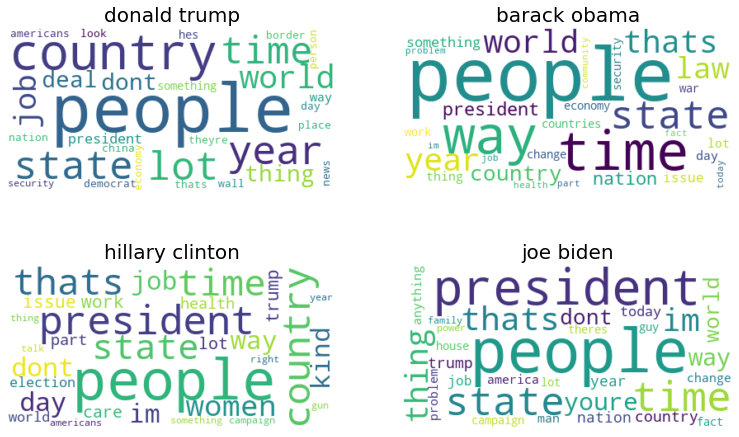

In [ ]:
fig = cloud(['donald trump', 'hillary clinton','barack obama', 'joe biden'], 1000, 30, final)

We can notice that there are some words in common for each of them, such as "people", "president" or "country", while some others are not used by them all, for example "women" used frequently by Hillary Clinton, or "China", "border", "wall" used by Donald Trump.

Now we want to dig deeper into the most commonly used words. In particular, thanks to the word frequency dataset and the `level_score` function previously defined, we want to assess the distribution of "academic" domain words against "spoken" domain ones, among the most commonly used words.

In [ ]:
nltk.download('averaged_perceptron_tagger')
import operator

top_words = [25, 50, 100, 150, 200, 250, 300, 400, 500]
Trump_s, Clinton_s, Obama_s, Biden_s = [], [], [], []
Trump_a, Clinton_a, Obama_a, Biden_a = [], [], [], []
Trump_s_std, Clinton_s_std, Obama_s_std, Biden_s_std = [], [], [], []
Trump_a_std, Clinton_a_std, Obama_a_std, Biden_a_std = [], [], [], []

for i in top_words:
  temp_t_s, temp_c_s, temp_b_s, temp_o_s = [], [], [], []
  temp_t_a, temp_c_a, temp_b_a, temp_o_a = [], [], [], []
  for j in range(4):
    f_t, _ = most_freq_words('donald trump', 1000, i, final)
    temp_t_s.append(level_score(f_t, verbose = False)[0])
    temp_t_a.append(level_score(f_t, verbose = False)[1])
    f_c, _ = most_freq_words('hillary clinton', 1000, i, final)
    temp_c_s.append(level_score(f_c, verbose = False)[0])
    temp_c_a.append(level_score(f_c, verbose = False)[1])
    f_b, _ = most_freq_words('joe biden', 1000, i, final)
    temp_b_s.append(level_score(f_b, verbose = False)[0])
    temp_b_a.append(level_score(f_b, verbose = False)[1])
    f_o, _ = most_freq_words('barack obama', 1000, i, final)
    temp_o_s.append(level_score(f_o, verbose = False)[0])
    temp_o_a.append(level_score(f_o, verbose = False)[1])
  
  # fill the mean and std lists for each politician for both academic and spoken words
  Trump_s.append(np.mean(temp_t_s))
  Trump_s_std.append(np.std(temp_t_s))
  Trump_a.append(np.mean(temp_t_a))
  Trump_a_std.append(np.std(temp_t_a))
  Clinton_s.append(np.mean(temp_c_s))
  Clinton_s_std.append(np.std(temp_c_s))
  Clinton_a.append(np.mean(temp_c_a))
  Clinton_a_std.append(np.std(temp_c_a))
  Biden_s.append(np.mean(temp_b_s))
  Biden_s_std.append(np.std(temp_b_s))
  Biden_a.append(np.mean(temp_b_a))
  Biden_a_std.append(np.std(temp_b_a))
  Obama_s.append(np.mean(temp_o_s))
  Obama_s_std.append(np.std(temp_o_s))
  Obama_a.append(np.mean(temp_o_a))
  Obama_a_std.append(np.std(temp_o_a))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Also in this case we firstly plot the distributions of academic and spoken domain words in a static and then interactive way.

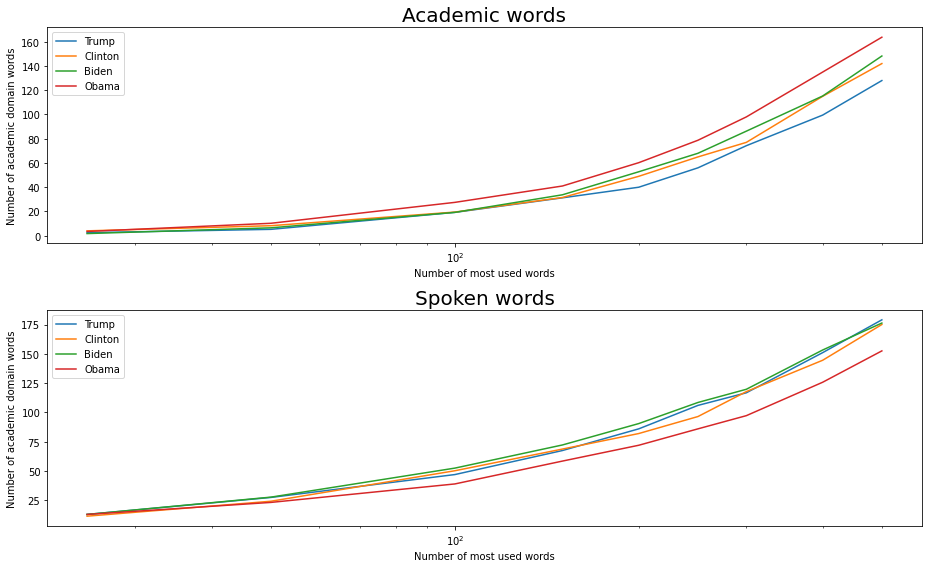

In [ ]:
fig, axs = plt.subplots(2)
axs[0].plot(top_words, Trump_a, label='Trump')
axs[0].plot(top_words, Clinton_a, label = 'Clinton')
axs[0].plot(top_words, Biden_a, label = 'Biden')
axs[0].plot(top_words, Obama_a, label = 'Obama')
axs[0].legend()
axs[0].set_title('Academic words', fontsize = 20)
axs[0].set_xscale('log')
axs[0].set_ylabel('Number of academic domain words')
axs[0].set_xlabel('Number of most used words')
axs[1].plot(top_words, Trump_s, label='Trump')
axs[1].plot(top_words, Clinton_s, label = 'Clinton')
axs[1].plot(top_words, Biden_s, label = 'Biden')
axs[1].plot(top_words, Obama_s, label = 'Obama')
axs[1].legend()
axs[1].set_ylabel('Number of academic domain words')
axs[1].set_xlabel('Number of most used words')
axs[1].set_title('Spoken words', fontsize = 20)
axs[1].set_xscale('log')
fig.tight_layout()

In [ ]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step, i in enumerate(top_words):
    fig.add_trace(
        go.Bar(
            visible=False,
            name="𝜈 = " + str(i),
            x=['Trump', 'Clinton', 'Obama', 'Biden'],
            y=[Trump_a[step], Clinton_a[step], Obama_a[step], Biden_a[step]],
            # confidence intervals
            error_y = {'array': (1.96/2)*np.array([Trump_a_std[step], Clinton_a_std[step], Obama_a_std[step], Biden_a_std[step]])},
            marker=dict(color = ['red', 'blue', 'green'],                 
            colorscale='viridis'))) 

fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(       
        label = str(top_words[i]),
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Number of academic language words among the top " + str(top_words[i]) + " used words."}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Number of most used words: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(yaxis_title="Numer of academic domain words",
    sliders=sliders
)
fig.update_yaxes(type = 'log')

fig.show()

In [ ]:
fig.write_html("/content/drive/MyDrive/ADA project/academic_words.html")

Also here, Obama is the one with the highest average number of academic words in every case. Also we notice that from considering the most used 100 words and above the relative frequency among the politicians seems to converge in this order of frequency of academic words: Obama, Biden, Clinton, Trump.

We now check what happens with the number of spoken language words.

In [ ]:

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step, i in enumerate(top_words):
    fig.add_trace(
        go.Bar(
            visible=False,
            name="𝜈 = " + str(i),
            x=['Trump', 'Clinton', 'Obama', 'Biden'],
            y=[Trump_s[step], Clinton_s[step], Obama_s[step], Biden_s[step]],
            error_y = {'array': (1.96/2)*np.array([Trump_s_std[step], Clinton_s_std[step], Obama_s_std[step], Biden_s_std[step]])},
            marker=dict(color = ['red', 'blue', 'green'],                 
            colorscale='viridis'))) 

fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        label = str(top_words[i]),
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Number of spoken words among the top " + str(top_words[i]) + " used words."}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Number of most used words: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(yaxis_title="Numer of spoken domain words",
    sliders=sliders
)
fig.update_yaxes(type = 'log')

fig.show()

In [ ]:
fig.write_html("/content/drive/MyDrive/ADA project/spoken_words.html")

Also in this case, a part from the first case with the top 25 words, Obama is clearly the one farthest from the others, with a lower frequency of spoken domain words. Joe Biden is quite steadily the one with the highest average number of spoken language words, while for Clinton and Trump we can perform a Wald test to assess when their results are statistically different.

DISCLAIMER: the dataset we used to tag the words either "academic" or "spoken" contains also many other tags. It is not true that a word is either academic or spoken. Moreover, the dataset contains 5000 words, so it may be that a word is not found in the dataset. 

In [ ]:
wald_tests2_tc = []
for i in range(len(top_words)):
  w_tc = (Trump_s[i] - Clinton_s[i])/np.sqrt(Trump_s_std[i]**2/4 + Clinton_s_std[i]**2/4)
  wald_tests2_tc.append(w_tc)

In [ ]:
test2_tc = np.abs(wald_tests2_tc) >= 1.645
for i, word in enumerate(top_words):
  if test2_tc[i]:
    print(f'Considering a window of {word} words the results of Trump and Clinton are statistically different \n')
  else:
    print(f'Considering a window of {word} words the results of Trump and Clinton are NOT statistically different \n')

Considering a window of 25 words the results of Trump and Clinton are statistically different 

Considering a window of 50 words the results of Trump and Clinton are statistically different 

Considering a window of 100 words the results of Trump and Clinton are NOT statistically different 

Considering a window of 150 words the results of Trump and Clinton are NOT statistically different 

Considering a window of 200 words the results of Trump and Clinton are NOT statistically different 

Considering a window of 250 words the results of Trump and Clinton are statistically different 

Considering a window of 300 words the results of Trump and Clinton are NOT statistically different 

Considering a window of 400 words the results of Trump and Clinton are statistically different 

Considering a window of 500 words the results of Trump and Clinton are statistically different 



They are always statistically not different a part when considering the 200 and 250 most used words, for which the average for Trump is higher.

Finally we also use the metrics retrieved usig the API Text Inspector to assess the readability scores of the four candidates.

In [ ]:
api = pd.read_csv("/content/drive/MyDrive/ADA project/statistics_df_important_ones.csv")
api = api.loc[[0,2,3,5]]
api

,Name,QID,Flesh_Reading_Ease,Flesh_Reading_Ease_std,Flesch-Kincaid_Grade,Flesch-Kincaid_Grade_std,Gunning_Fog_index,Gunning_Fog_index_std,MTLD,MTLD_std,VOCD,VOCD_std,CEFR_level,CEFR_num_metrics,CEFR_percentage,unique_words,std_unique_words,spoken_words,acad_words
0,donald trump,Q22686,63.464,2.337,9.436,0.626,12.498,0.674,127.168,5.807,93.736,9.366,C2,29,72.18,613.423,19.986,121,77
2,hillary clinton,Q6294,58.128,1.601,11.250,0.361,14.444,0.428,126.810,17.187,113.372,23.777,C2,29,72.41,622.436,16.713,117,80
3,barack obama,Q76,48.634,2.594,13.506,0.555,16.886,0.589,123.906,13.689,112.754,16.945,C2,27,74.57,653.610,17.694,106,81
5,joe biden,Q6279,64.540,1.348,9.346,0.382,12.570,0.369,124.380,11.068,88.378,8.074,C1+,30,67.56,605.846,14.662,135,78


We group the statistics result to prepare for graphical inspection

In [ ]:
Trump_api = list(api.iloc[0, [2,4,6,8,10]])
Trump_api_std = list(api.iloc[0, [3,5,7,9,11]])
Clinton_api = list(api.iloc[1, [2,4,6,8,10]])
Clinton_api_std = list(api.iloc[1, [3,5,7,9,11]])
Obama_api = list(api.iloc[2, [2,4,6,8,10]])
Obama_api_std = list(api.iloc[2, [3,5,7,9,11]])
Biden_api = list(api.iloc[3, [2,4,6,8,10]])
Biden_api_std = list(api.iloc[3, [3,5,7,9,11]])

statistics = ['Flesh_Reading_Ease', 'Flesch-Kincaid_Grade', 'Gunning_Fog_index', 'MTLD', 'VOCD']

We create an interactive bar chart, it is possible to change the metric and see the corresponding value for each politician.

In [ ]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step, i in enumerate(statistics):
    fig.add_trace(
        go.Bar(
            visible=False,
            name="𝜈 = " + str(i),
            x=['Trump', 'Clinton', 'Obama', 'Biden'],
            y=[Trump_api[step], Clinton_api[step], Obama_api[step], Biden_api[step]],
            error_y = {'array': 1.96/2*np.array([Trump_api_std[step], Clinton_api_std[step], Obama_api_std[step], Biden_api_std[step]])},
            marker=dict(color = ['red', 'blue', 'green'],                 
            colorscale='viridis'))) 

fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        label = str(statistics[i]),
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Statistic: " + str(statistics[i])}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Statistic: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(#yaxis_title="Numer of different words",
    sliders=sliders
)
fig.update_yaxes(type = 'log')

fig.show()

In [ ]:
fig.write_html("/content/drive/MyDrive/ADA project/api_important.html")

The results coming from the first three metrics provided by the API confirm what we guessed from the words frequency and most used words: Barack Obama is the one with the most complex communication style and the widest words spectrum, while Donald Trump and Joe Biden are those with the worst results.
Regarding the MTLD and VOCD metrics there is a high variability depending on the subset of quotations analyzed, showing the little robustness of the metric used on such data (random quotations aggregated to form texts), therefore they do not show reliable results, for more accurate results regarding the lexical spectrum refer to the `frequency` function.

# General Analysis and Graphs

We now want to shift our attention to comparing groups of politicians, which was essentially the goal of this whole project. We would like to investigate whether the trends seen in the individual comparisons we draw in the previous section can be extended to more general tendencies, aggregating the Senators and Congressmen with quotes included inside Quotebank for party, branch of Congress, age, state of election and other...

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import shapely
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import geojson
import plotly.io as pio
# pio.renderers.default = 'browser'

Firstly we need to import a geojson file that will then be used to draw borders of American States and extract the names of the states of election of each politician included in the Voteview database

In [ ]:
us_states = json.load(open("/content/drive/MyDrive/ADA project/us-state-boundaries.geojson", 'r'))
state_abbr_map = {}
state_id_map = {}
for feature in us_states["features"]:
    feature["id"] = int(feature["properties"]["state"])
    feature["name"] = feature["properties"]["name"]
    state_abbr_map[int(feature["properties"]["state"])] = feature["name"] # We created a dictionary to map states from abbreviation to full name (e.g. NY to New York)
    state_id_map[feature["properties"]["stusab"]] = feature["id"] # We created a dictionary of the states, from abbreviation to state id, useful to then map values inside the map representation

We now merge the dataset with the average lexical statistics computed on all the quotes of each Senator or Congressman, to map be able to aggregate values afterwards. We also perform some useful transformation such as creating the column `party` instead of `party_code` to more easily select Democrats and/or Republicans; applying the `state_abbr_map` created above; and finally include each individual inside one of the 5 age groups (based on the year of birth). 


In [ ]:
voteview = pd.read_csv("/content/drive/MyDrive/ADA project/congressmembers_senators_unique.csv")
statistics = pd.read_csv("/content/drive/MyDrive/ADA project/statistics.csv")

df_merge = statistics.merge(voteview, on='QID')
df_merge.drop(4, inplace=True)

df_merge['state_id'] = df_merge['state_abbrev'].apply(lambda x: state_id_map[x])
df_merge['state_name'] = df_merge.state_id.apply(lambda x: state_abbr_map[x])

df_merge['born_decade'] = df_merge.born.apply(lambda x: str(int(x))[-2] + "0s")
born_map = {'20s': 0, '30s': 0,'40s': 1, '50s': 2, '60s': 3, '70s': 4, '80s': 4}
df_merge['born_group'] = df_merge.born_decade.apply(lambda x: born_map[x])
borng_group_map = {0:'<40s', 1:'40s', 2:'50s', 3:'60s', 4:'>60s'}
df_merge['born_group_cat'] = df_merge.born_group.apply(lambda x: borng_group_map[x])

party_map = {100: 'Democrats', 200:'Republicans', 328:'Independents'}
df_merge['party'] = df_merge.party_code.apply(lambda x: party_map[x])

df_merge = df_merge[['bioname','Flesh_Reading_Ease', 'Flesch-Kincaid_Grade', 'Gunning_Fog_index', 'unique_words',
                'spoken_words', 'acad_words', 'congress','chamber', 'party_code', 'party', 'born', 'born_decade',
                 'born_group', 'born_group_cat', 'state_id', 'state_abbrev', 'state_name']]

dff = df_merge.copy()
dff = dff.loc[~(dff.party == 'Independents')] 
#we remove politicians belonging to the independent party as they are only 2 as we can see from the graph below but make comparisons and graphs much more easy to read. 
# Additionally our goal is to focus on the 2 major parties also because they can be more easily analized given their size

We are now ready to present what are the distribution for various features of the individual that have quotes present in Quotebank and that we are going to analize to compute aggregate metrics. 
In particular here below in order we present how they are splitted between parties, which Congress' branch they sit in, to what year of birth group they belong to, which was their first congress in the range selected (114th to 116th). So if a politician was present in all congresses it will appear in the 114th, while if he entered only after the 2016 elections he will appear as belonging to the 115th. 

In [ ]:
fig = px.sunburst(dff, path=['congress'], color='congress', color_continuous_scale='Greens_r')
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/pie_congress.html") #we save those in html to import them include the graphs in the datastory

fig = px.sunburst(dff, path=['state_name'], color='born', color_continuous_scale='Reds')
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/pie_state.html")

We can notice the politicians taken into account are balanced between Democrats and Republicans. Clearly there are many more Congressmen than Senators as it's natural given the House of Representatives is composed by 435 members, while the Senate includes only 100 individuals. 
Age-wise we can see that the majority of US Representatives included in our metrics were born in the 50s and 60s, and only 115 out of 539 considered were born in the 70s or later. 
Naturally by the way each congressman is assigned to a number of congress the 114th is the most represented. 58 is the number of politicians considered who were first elected in 2016 (first mandate during the 115th Congress), while this number increases to 77 for the midterm elections of 2018. 

We also plotted some Sunburst charts to give a more clear picture of the distribution of age, first congress appearance per each branch of the Congress as well as per party.

In [ ]:
fig = px.sunburst(dff, path=['party','chamber','born_group_cat'], color='party')
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/sunburst_1.html")

fig = px.sunburst(dff, path=['chamber','born_group_cat'], color='chamber')
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/sunburst_2.html")

fig = px.sunburst(dff, path=['chamber','party','born_group_cat'], color='party')
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/sunburst_3.html")

We can notice various things: 
1. From the first graph we notice that the percentage of members of each party belonging to the House of Representatives is mostly consistent between Democrats and Republicans 224 to 218, while Republicans count 56 senators v. 41 for the Dem in our dataset. 
Democrats in both chambers seem to have a younger range of representatives. for example those born after the 60s represent the most popoulous group at the House of Representatives among Democrats, while they only figure on 3rd place for Republicans (57 v. 49)
2. The Senate is composed (naturally given the Corsus Honorum strongly felt in the US) by older people. In particular people born in the 40s or earlier represent just 17% in the House of Representatives versus one third of the Senate. 
3. In this last one we can see even more clearly what said for the first suburst graph. Especially if we select by clicking on the particular sections of the circle Democrats>House and compare to Republicans>House

We will now move to analyze the aggregated values of the metrics chosen to measure the lexical level of the politicians we are considering. 
We will start by analyzing the distribution of `Flesh_Reading_Ease` scores across the two major parties.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_merge.loc[df_merge.party == 'Democrats']['Flesh_Reading_Ease'],
                           name = 'Democrats', histnorm='probability', opacity=1))
fig.add_trace(go.Histogram(x=df_merge.loc[df_merge.party == 'Republicans']['Flesh_Reading_Ease'],
                           name = 'Republicans', histnorm='probability', opacity=0.7))

fig.update_layout(barmode='overlay', bargap=0.05, xaxis_title = 'Flesh Reading Ease Score', yaxis_title = 'Relative Frequency',
                  title = 'Distribution of Flesh Reading Ease for the two parties')
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/hist_party.html")

We can notice that the distribution of the scores are shifted to the right for Republicans, which can be interpreted (using the definition of the Flesh Reading Ease Score) by saying that Republicans in general use more simple sentences constructions. To verify the soundness of such hypothesis we run a t-test here below:

In [ ]:
dem = dff[dff.party == 'Democrats']
rep = dff[dff.party == 'Republicans']

ttest_ind(dem['Flesh_Reading_Ease'], rep['Flesh_Reading_Ease'])

Ttest_indResult(statistic=-3.5848082531953485, pvalue=0.00036806896295612856)

With a p-value of 0.0003 we can safely reject the null-hypothesis stating there is no statistical difference between the `Flesh Reading Ease` scores of Republicans and Democrats. We would like to know if the other two metric are consistent, to do that we run other two t-test to confirm or reject the same hypothesis these times on `Flesch-Kincaid Grade` and `Gunning Fog Index` scores.


In [ ]:
print('avg Flesch-Kincaid Grade score for Democrats:   ' + str(dem['Flesch-Kincaid_Grade'].mean()))
print('avg Flesch-Kincaid Grade score for Republicans: ' + str(rep['Flesch-Kincaid_Grade'].mean()) + '\n')

ttest_ind(dem['Flesch-Kincaid_Grade'], rep['Flesch-Kincaid_Grade'])

avg Flesch-Kincaid Grade score for Democrats:   14.194181132075473
avg Flesch-Kincaid Grade score for Republicans: 13.67987956204379



Ttest_indResult(statistic=3.7046578672147286, pvalue=0.00023360047916305322)

In [ ]:
print('avg Gunning Fox Index score for Democrats:   ' + str(dem['Gunning_Fog_index'].mean()))
print('avg Gunning Fox Index score for Republicans: ' + str(rep['Gunning_Fog_index'].mean())  + '\n')

ttest_ind(dem['Gunning_Fog_index'], rep['Gunning_Fog_index'])

avg Gunning Fox Index score for Democrats:   17.801709433962273
avg Gunning Fox Index score for Republicans: 17.30128102189782



Ttest_indResult(statistic=3.4396240285712456, pvalue=0.0006277962617384701)

From the results here above we can indeed verify that the results of the 3 metrics are consistent, given the way they are computed the fact that Democrats have statistically significant higher scores in these last two metrics confirms the intuition of the Flesh Reading Ease analysis which made us state Democrats in general speak with more complex sentences' structures. 

Now that we have confirmed that there is indeed a significant difference between Republicans and Democrats we asked ourselves whether there other significant differences besides the one between parties. 

To do so we first need to create the necessary datasets to analyse the data aggregated in different ways, which we do in the cell below.

In particular we want to analyse possible differences between the two branches of the Congress, between age groups and for first appearance in Congress. So here below we create for this purpose: `df_chamber` , `df_age` and `df_congr`. In all analysis we will take into account the difference between Republicans and Democrats and therefore analyse possible differences only across individuals of the same party. In fact, as we have seen in the initial analysis of the population of our sample (with pie-charts and suburst-charts) many sub-aggregation of the data are not perfectly balanced between Democrats and Republicans. Therefore this is necessary to extract meaningful information.  

In [ ]:
### df_chamber ###

df_chamber = dff.groupby(['chamber','party']).mean()
df_chamber = df_chamber.merge(dff.groupby(['chamber','party']).std(), on=['chamber','party'], suffixes=('','_std'))
df_chamber = df_chamber.merge(dff.groupby(['chamber','party']).count()['bioname'], on=['chamber','party'])

df_chamber['Flesh_Reading_Ease_CI'] = 1.96 * (df_chamber['Flesh_Reading_Ease_std'] / np.sqrt(df_chamber['bioname']))
df_chamber['Flesch-Kincaid_Grade_CI'] = 1.96 * (df_chamber['Flesch-Kincaid_Grade_std'] / np.sqrt(df_chamber['bioname']))
df_chamber['Gunning_Fog_index_CI'] = 1.96 * (df_chamber['Gunning_Fog_index_std'] / np.sqrt(df_chamber['bioname']))

df_chamber['chamber'] = df_chamber.index.to_numpy()
df_chamber['party'] = df_chamber.chamber.apply(lambda x: x[1])
df_chamber['chamber'] = df_chamber.chamber.apply(lambda x: x[0])

#________________________________________________________________________#

### df_age ###

df_age = dff.groupby(['born_group','party']).mean()
df_age = df_age.merge(dff.groupby(['born_group','party']).std(), on=['born_group','party'], suffixes=('','_std'))
df_age = df_age.merge(dff.groupby(['born_group','party']).count()['bioname'], on=['born_group','party'])

df_age['Flesh_Reading_Ease_CI'] = 1.96 * (df_age['Flesh_Reading_Ease_std'] / np.sqrt(df_age['bioname']))
df_age['Flesch-Kincaid_Grade_CI'] = 1.96 * (df_age['Flesch-Kincaid_Grade_std'] / np.sqrt(df_age['bioname']))
df_age['Gunning_Fog_index_CI'] = 1.96 * (df_age['Gunning_Fog_index_std'] / np.sqrt(df_age['bioname']))

df_age['born_group'] = df_age.index.to_numpy()
df_age['party'] = df_age.born_group.apply(lambda x: x[1])
df_age['born_group'] = df_age.born_group.apply(lambda x: x[0])
df_age['born_group'] = df_age.born_group.apply(lambda x: borng_group_map[x])

#__________________________________________________________________________#

### df_congress ###

df_congr = dff.groupby(['congress','party']).mean()
df_congr = df_congr.merge(dff.groupby(['congress','party']).std(), on=['congress','party'], suffixes=('','_std'))
df_congr = df_congr.merge(dff.groupby(['congress','party']).count()['bioname'], on=['congress','party'])

df_congr['Flesh_Reading_Ease_CI'] = 1.96 * (df_congr['Flesh_Reading_Ease_std'] / np.sqrt(df_congr['bioname']))
df_congr['Flesch-Kincaid_Grade_CI'] = 1.96 * (df_congr['Flesch-Kincaid_Grade_std'] / np.sqrt(df_congr['bioname']))
df_congr['Gunning_Fog_index_CI'] = 1.96 * (df_congr['Gunning_Fog_index_std'] / np.sqrt(df_congr['bioname']))

df_congr['congress'] = df_congr.index.to_numpy()
df_congr['party'] = df_congr.congress.apply(lambda x: x[1])
df_congr['congress'] = df_congr.congress.apply(lambda x: x[0])

We start by analysing whethere there is a difference in the way Senators speak compared to Representatives. We therefore plot values of the three metrics for each party.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name='House', x=df_chamber.loc[(df_chamber.chamber == 'House')]['party'],
                     y=df_chamber.loc[(df_chamber.chamber == 'House')]['Flesh_Reading_Ease'],
                     marker_color = 'goldenrod', error_y=dict(type='data',
                                  array=df_chamber.loc[(df_chamber.chamber == 'House')]['Flesh_Reading_Ease_CI'])))

fig.add_trace(go.Bar(name='Senate', x=df_chamber.loc[(df_chamber.chamber == 'Senate')]['party'],
                     y=df_chamber.loc[(df_chamber.chamber == 'Senate')]['Flesh_Reading_Ease'], 
                     marker_color = '#316395', error_y=dict(type='data',
                                  array=df_chamber.loc[(df_chamber.chamber == 'Senate')]['Flesh_Reading_Ease_CI'])))

fig.update_layout(barmode='group', xaxis_title = 'Party', yaxis_title = 'Flesh Reading Ease',
                  title_text = "Flesh Reading Ease scores for the two parties", title_font_size = 16)
fig.update_yaxes(range=[38,50]) 
#select initial range to improve visualization, can always be modified inside the graph 

fig.show()

fig.write_html("/content/drive/MyDrive/ADA project/graph_chamber_flesh_ease.html")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name='House', x=df_chamber.loc[(df_chamber.chamber == 'House')]['party'],
                     y=df_chamber.loc[(df_chamber.chamber == 'House')]['Flesch-Kincaid_Grade'],
                     marker_color = 'goldenrod', error_y=dict(type='data',
                                  array=df_chamber.loc[(df_chamber.chamber == 'House')]['Flesch-Kincaid_Grade_CI'])))

fig.add_trace(go.Bar(name='Senate', x=df_chamber.loc[(df_chamber.chamber == 'Senate')]['party'],
                     y=df_chamber.loc[(df_chamber.chamber == 'Senate')]['Flesch-Kincaid_Grade'], 
                     marker_color = '#316395', error_y=dict(type='data',
                                  array=df_chamber.loc[(df_chamber.chamber == 'Senate')]['Flesch-Kincaid_Grade_CI'])))

fig.update_layout(barmode='group', xaxis_title = 'Party', yaxis_title = 'Flesch-Kincaid Grade',
                  title_text = "Flesch-Kincaid Grade scores for the two parties", title_font_size = 16)
fig.update_yaxes(range=[12,15]) 
#select initial range to improve visualization, can always be modified inside the graph 

fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/graph_chamber_flesh_grade.html")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name='House', x=df_chamber.loc[(df_chamber.chamber == 'House')]['party'],
                     y=df_chamber.loc[(df_chamber.chamber == 'House')]['Gunning_Fog_index'],
                     marker_color = 'goldenrod', error_y=dict(type='data',
                                  array=df_chamber.loc[(df_chamber.chamber == 'House')]['Gunning_Fog_index_CI'])))

fig.add_trace(go.Bar(name='Senate', x=df_chamber.loc[(df_chamber.chamber == 'Senate')]['party'],
                     y=df_chamber.loc[(df_chamber.chamber == 'Senate')]['Gunning_Fog_index'], 
                     marker_color = '#316395', error_y=dict(type='data',
                                  array=df_chamber.loc[(df_chamber.chamber == 'Senate')]['Gunning_Fog_index_CI'])))

fig.update_layout(barmode='group', xaxis_title = 'Party', yaxis_title = 'Gunning Fog Index',
                  title_text = "Gunning Fog Index scores for the two parties", title_font_size = 16)
fig.update_yaxes(range=[16,19]) 
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/graph_chamber_gunning_fox.html")

From the 3 graphs ahead we can see that the only difference remain between the two different parties while for all three measure of lexical level there is no difference between Senators and Representatives inside the same party. 

The next questions we asked ourselves was: is there any significant difference between age groups? To answer that we used the same approach as done with parliament branches and compared values for each age group splitted between Democrats and Republicans.

In [ ]:
colors =  {'Democrats':'steelblue', 'Republicans':'firebrick'}

layout = go.Layout(title="Flesh Reading Ease scores for age groups", xaxis=dict(title="Party"), yaxis=dict(title="Flesh_Reading_Ease")) 
fig=go.Figure(layout=layout) 

for t in df_age['party'].unique():
    dfp = df_age[df_age['party']==t]
    fig.add_traces(go.Bar(x=dfp['born_group'], y = dfp['Flesh_Reading_Ease'], name=t,
                         marker_color=colors[t], error_y=dict(type='data', array=dfp['Flesh_Reading_Ease_CI'])))
    
fig.update_yaxes(range=[36,50]) 
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/graph_age_flesh_ease.html")

First from the graph above we can notice that Democrats keep recording lower `Flesh Reading Ease` values in all age groups. But what we are more intrested in analysing possible trends among age groups for each party. So we replot the same graph now grouping bars by party, such graph is shown below:

In [ ]:
colors =  ('steelblue','firebrick')

layout = go.Layout({'title':"Flesh Reading Ease scores for age groups", "xaxis":{'title':'For each party values for politicians born in the {<40s, 40s, 50s, 60s, >60s}'}, 'yaxis':{'title':"Flesh_Reading_Ease"} ,
                       "showlegend": False})
fig=go.Figure(layout=layout) 

for t in df_age['born_group'].unique():
    dfp = df_age[df_age['born_group']==t]
    fig.add_traces(go.Bar(x=dfp['party'], y = dfp['Flesh_Reading_Ease'], marker_color=colors,
                          name=t, error_y=dict(type='data', array=dfp['Flesh_Reading_Ease_CI'])))
fig.update_yaxes(range=[36,51]) 

fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/graph_age_flesh_ease_2.html")

From the graph just plotted we can notice a steady trend among Republicans. It seems that younger Republican congressmen progressively adopted a more simple lexic. Even though differences seem really small and looking at confidence intervals we could not clearly reject null hypothesis of averages being identical. 
The other thing we noticed from the previous graph is that Democrats born in 1970 or later score statistically significant higher Flesh Reading Ease scores that older colleagues. While all other Democrats across the remaining age groups seem to score consistently. 

Next questions we asked ourselves is: is there a statistically significant difference in lexical complexity for politicians who entered later in Congress during recent elections? 
To reply to such question we plot the same graphs as above this time differentiating for the congress of first appearance. 

In [ ]:
colors =  {'Democrats':'steelblue', 'Republicans':'firebrick'}

layout = go.Layout(title="Flesh Reading Ease scores for first congress of appeareance", xaxis=dict(title="Party"), yaxis=dict(title="Flesh_Reading_Ease")) 
fig=go.Figure(layout=layout) 

for t in df_congr['party'].unique():
    dfp = df_congr[df_congr['party']==t]
    fig.add_traces(go.Bar(x=dfp['congress'], y = dfp['Flesh_Reading_Ease'], name=t,
                         marker_color=colors[t], error_y=dict(type='data', array=dfp['Flesh_Reading_Ease_CI'])))
    
fig.update_yaxes(range=[36,51]) 
fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/graph_congress_flesh_ease.html")


colors =  ('steelblue','firebrick')
layout = go.Layout({'title':"Flesh Reading Ease scores for first congress of appeareance", "xaxis":{'title':'For each party values for 114th, 115th and 116th congress'}, 'yaxis':{'title':"Flesh_Reading_Ease"} ,
                       "showlegend": False})
fig=go.Figure(layout=layout) 

for t in df_congr['congress'].unique():
    dfp = df_congr[df_congr['congress']==t]
    fig.add_traces(go.Bar(x=dfp['party'], y = dfp['Flesh_Reading_Ease'], marker_color=colors,
                          name=str(t), error_y=dict(type='data', array=dfp['Flesh_Reading_Ease_CI'])))
fig.update_yaxes(range=[36,51]) 

fig.show()
fig.write_html("/content/drive/MyDrive/ADA project/graph_congress_flesh_ease_2.html")


From the two graphs above we can notice that the difference between Democrats and Republicans remain true for each sub group of politician who entered the congress in 2015, 2017 or 2019, corresponding respectively to the 114th, 115th and 116th congresses. 

In addition we can notice that the lexic chosen by politicians who more recently entered in congress is generally more simple, less refined. This can be seen both among Republicans as well as Democrats.

Finally, we asked ourselves if we could notice some significant differences for politicians elected in different US states. To do so we show an interactive map where we can visualize the aggregated values for the Flesh Reading Ease scores for each state, where we can also select individual parties and branches of the Congress. 

To do so we firstly need to create a specific dataset `df_map`, where we report aggregated values of politicians for each state, selecting single branches of the Congress or the entire congress, as well as selecting only Democrats or Republicans as well as both parties. To do so we cannot use groupby as it would not return us a distinct row for the unaggregated statistics. 

In [ ]:
df_map00 = dff.loc[(dff.party_code == 100) & (dff.chamber == 'House')].groupby('state_abbrev').mean()
df_map01 = dff.loc[(dff.party_code == 200) & (dff.chamber == 'House')].groupby('state_abbrev').mean()
df_map02 = dff.loc[dff.chamber == 'House'].groupby('state_abbrev').mean()

df_map10 = dff.loc[(dff.party_code == 100) & (dff.chamber == 'Senate')].groupby('state_abbrev').mean()
df_map11 = dff.loc[(dff.party_code == 200) & (dff.chamber == 'Senate')].groupby('state_abbrev').mean()
df_map12 = dff.loc[dff.chamber == 'Senate'].groupby('state_abbrev').mean()

df_map20 = dff.loc[dff.party_code == 100].groupby('state_abbrev').mean()
df_map21 = dff.loc[dff.party_code == 200].groupby('state_abbrev').mean()
df_map22 = dff.groupby('state_abbrev').mean()

df_map00c = dff.loc[(dff.party_code == 100) & (dff.chamber == 'House')][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})
df_map01c = dff.loc[(dff.party_code == 200) & (dff.chamber == 'House')][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})
df_map02c = dff.loc[dff.chamber == 'House'][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})

df_map10c = dff.loc[(dff.party_code == 100) & (dff.chamber == 'Senate')][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})
df_map11c= dff.loc[(dff.party_code == 200) & (dff.chamber == 'Senate')][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})
df_map12c = dff.loc[dff.chamber == 'Senate'][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})

df_map20c = dff.loc[dff.party_code == 100][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})
df_map21c = dff.loc[dff.party_code == 200][[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})
df_map22c = dff[[
    'Flesh_Reading_Ease','state_abbrev']].groupby('state_abbrev').count().rename(columns={'Flesh_Reading_Ease':'count'})

df_map00 = df_map00.merge(df_map00c, on='state_abbrev')
df_map01 = df_map01.merge(df_map01c, on='state_abbrev')
df_map02 = df_map02.merge(df_map02c, on='state_abbrev')

df_map10 = df_map10.merge(df_map10c, on='state_abbrev')
df_map11 = df_map11.merge(df_map11c, on='state_abbrev')
df_map12 = df_map12.merge(df_map12c, on='state_abbrev')

df_map20 = df_map20.merge(df_map20c, on='state_abbrev')
df_map21 = df_map21.merge(df_map21c, on='state_abbrev')
df_map22 = df_map22.merge(df_map22c, on='state_abbrev')

df_map00['chamber'] = 'House'
df_map00['party'] = 'Democrats'
df_map01['chamber'] = 'House'
df_map01['party'] = 'Republicans'
df_map02['chamber'] = 'House'
df_map02['party'] = 'All'

df_map10['chamber'] = 'Senate'
df_map10['party'] = 'Democrats'
df_map11['chamber'] = 'Senate'
df_map11['party'] = 'Republicans'
df_map12['chamber'] = 'Senate'
df_map12['party'] = 'All'

df_map20['chamber'] = 'Entire Congress'
df_map20['party'] = 'Democrats'
df_map21['chamber'] = 'Entire Congress'
df_map21['party'] = 'Republicans'
df_map22['chamber'] = 'Entire Congress'
df_map22['party'] = 'All'

We now also create a discrete score for Flesh Reading Ease: Low or High to distinguish states with high and low average scores. 

In [ ]:
df_map = df_map00.append(df_map01.append(df_map02.append(df_map10.append(df_map11.append(df_map12.append(df_map20.append(df_map21.append(df_map22))))))))
df_map['flesh_discr'] = ''
df_map.flesh_discr.loc[df_map['Flesh_Reading_Ease'] <= 44.5] = 'Low'
df_map.flesh_discr.loc[df_map['Flesh_Reading_Ease'] > 44.5] = 'High'
df_map = df_map.round(decimals=3)

df_map['state_id'] = df_map.state_id.apply(lambda x: int(x))
df_map['state_name'] = df_map.state_id.apply(lambda x: state_abbr_map[x])

Here we create an interactive map with Dash. The cell is not run because it needs to be run live to work, but the interactive version is available on our data story website, and also [here](https://prova-robi-cera.herokuapp.com).

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
server = app.server

app.layout = html.Div([html.Div([html.H1("Map of Politicians Lexical Skills", style={'size':'20vh', 'text-align': 'left'})]),
             html.Div([dcc.Dropdown(id="slct_chamber", options=[{"label": "House of Representatives", "value": 'House'},
                                                                {"label": "Senate", "value": 'Senate'},
                                                                {"label": "Entire Congress", "value": 'Entire Congress'}],
                                    multi=False, value='Entire Congress', style={'width': '30%', 'display': 'inline-block'}),
                       dcc.Dropdown(id="slct_party", options=[{"label": "Democrats", "value": 'Democrats'},
                                                              {"label": "Republicans", "value": 'Republicans'},
                                                              {"label": "All", "value": 'All'}],
                                    multi=False, value='All', style={'width': '30%', 'display': 'inline-block'}),
                       dcc.Dropdown(id="slct_metric", options=[{"label": "Flesh Reading Ease", "value": 'Flesh_Reading_Ease'},
                                                               {"label": "High or Low Flesh Reading", "value": 'flesh_discr'}],
                                    multi=False, value='flesh_discr', style={'width': '35%', 'display': 'inline-block'})
                      ]),
            html.Div([dcc.Graph(id='us_map',style={'width': '120vh', 'height': '80vh'})])])

@app.callback(Output('us_map', 'figure'),
    Input('slct_chamber', 'value'),
    Input('slct_party', 'value'),
    Input('slct_metric', 'value'))

def update_graph(slct_chamber, slct_party, slct_metric):
    
    print(slct_chamber, slct_party, slct_metric)
    
    dff = df_map.copy()
    dff = dff.loc[(dff["chamber"] == slct_chamber) & (dff["party"] == slct_party)]
    
    fig = px.choropleth(dff, locations='state_id', geojson=us_states,
              color=slct_metric, scope = 'usa', hover_name = 'state_name',
                        range_color=(34,60), color_discrete_map={'High':'firebrick','Low':'steelblue'},
                       color_continuous_scale = "bluered",
                        hover_data={'count':True,'Flesh_Reading_Ease':True, 'flesh_discr':True, 'state_id':False})

    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

# T-Tests to check statistical difference among different groups

In this section, we check whether there is a significant difference in language within these 6 different groupings:

1. Democrats vs Repubblicans
2. House members vs Senate member
3. House Democrats vs House Repubblicans
4. Senate Democrats vs Sanate Repubblicans
5. House Democrats vs Senate Democrats
6. House Repubblicans vs Senate Repubblicans

We run a t-test for each of the three metrics: Flesh_Reading_Ease (fre), Flesch-Kincaid_Grade (fkg), Gunning_Fog_index (gfi).

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
df = dff.copy()

## First test: Democrats vs Repubblicans

In [ ]:
df_dem = df[df["party_code"] == 100]
df_rep = df[df["party_code"] == 200]

In [ ]:
fre_rep = df_rep["Flesh_Reading_Ease"]
fre_dem = df_dem["Flesh_Reading_Ease"]

fkg_rep = df_rep["Flesch-Kincaid_Grade"]
fkg_dem = df_dem["Flesch-Kincaid_Grade"]

gfi_rep = df_rep["Gunning_Fog_index"]
gfi_dem = df_dem["Gunning_Fog_index"]

In [ ]:
ttest_ind(fre_dem, fre_rep)

Ttest_indResult(statistic=-3.5848082531953485, pvalue=0.00036806896295612856)

In [ ]:
ttest_ind(fkg_dem, fkg_rep)

Ttest_indResult(statistic=3.7046578672147286, pvalue=0.00023360047916305322)

In [ ]:
ttest_ind(gfi_dem, gfi_rep)

Ttest_indResult(statistic=3.4396240285712456, pvalue=0.0006277962617384701)

## Second test: House vs Senate

In [ ]:
df_house = df[df["chamber"] == "House"]
df_senate = df[df["chamber"] == "Senate"]

In [ ]:
fre_house = df_house["Flesh_Reading_Ease"]
fre_senate = df_senate["Flesh_Reading_Ease"]

fkg_house = df_house["Flesch-Kincaid_Grade"]
fkg_senate = df_senate["Flesch-Kincaid_Grade"]

gfi_house = df_house["Gunning_Fog_index"]
gfi_senate = df_senate["Gunning_Fog_index"]

In [ ]:
ttest_ind(fre_house, fre_senate)

Ttest_indResult(statistic=-0.1527351216927071, pvalue=0.8786645334028682)

In [ ]:
ttest_ind(fkg_house, fkg_senate)

Ttest_indResult(statistic=0.6667612361852914, pvalue=0.5052110282011135)

In [ ]:
ttest_ind(gfi_house, gfi_senate)

Ttest_indResult(statistic=0.42789485972501634, pvalue=0.668899217731718)

## Third test: House Democrats vs House Republicans

In [ ]:
df_house_dem = df_house[df_house["party_code"] == 100]

In [ ]:
df_house_rep = df_house[df_house["party_code"] == 200]

In [ ]:
fre_house_dem = df_house_dem["Flesh_Reading_Ease"]
fre_house_rep = df_house_rep["Flesh_Reading_Ease"]

fkg_house_dem = df_house_dem["Flesch-Kincaid_Grade"]
fkg_house_rep = df_house_rep["Flesch-Kincaid_Grade"]

gfi_house_dem = df_house_dem["Gunning_Fog_index"]
gfi_house_rep = df_house_rep["Gunning_Fog_index"]

In [ ]:
ttest_ind(fre_house_dem, fre_house_rep)

Ttest_indResult(statistic=-3.33171258883033, pvalue=0.0009359470772888494)

In [ ]:
ttest_ind(fkg_house_dem, fkg_house_rep)

Ttest_indResult(statistic=3.252863273959184, pvalue=0.0012304555480146695)

In [ ]:
ttest_ind(gfi_house_dem, gfi_house_rep)

Ttest_indResult(statistic=3.0729145681291277, pvalue=0.0022514798945438815)

##  Fourth test: Senate Democrats vs Senate Republicans

In [ ]:
df_senate_dem = df_senate[df_senate["party_code"] == 100]

In [ ]:
df_senate_rep = df_senate[df_senate["party_code"] == 200]

In [ ]:
fre_senate_dem = df_senate_dem["Flesh_Reading_Ease"]
fre_senate_rep = df_senate_rep["Flesh_Reading_Ease"]

fkg_senate_dem = df_senate_dem["Flesch-Kincaid_Grade"]
fkg_senate_rep = df_senate_rep["Flesch-Kincaid_Grade"]

gfi_senate_dem = df_senate_dem["Gunning_Fog_index"]
gfi_senate_rep = df_senate_rep["Gunning_Fog_index"]

In [ ]:
ttest_ind(fre_senate_dem, fre_senate_rep)

Ttest_indResult(statistic=-1.35413709451792, pvalue=0.17890504274886163)

In [ ]:
ttest_ind(fkg_senate_dem, fkg_senate_rep)

Ttest_indResult(statistic=1.690748073664234, pvalue=0.0941634841532263)

In [ ]:
ttest_ind(gfi_senate_dem, gfi_senate_rep)

Ttest_indResult(statistic=1.5007950299385564, pvalue=0.13672495925985)

##  Fifth test: House Democrats vs Senate Democrats

In [ ]:
ttest_ind(fre_house_dem, fre_senate_dem)

Ttest_indResult(statistic=0.06563450655556538, pvalue=0.9477186792508722)

In [ ]:
ttest_ind(fkg_house_dem, fkg_senate_dem)

Ttest_indResult(statistic=-0.06425966083002194, pvalue=0.9488122874039815)

In [ ]:
ttest_ind(gfi_house_dem, gfi_senate_dem)

Ttest_indResult(statistic=-0.12068262989294654, pvalue=0.9040345637778913)

##  Sixth test: House Repubblicans vs Senate Repubblicans

In [ ]:
ttest_ind(fre_house_rep, fre_senate_rep)

Ttest_indResult(statistic=0.04458817023716908, pvalue=0.9644682881157346)

In [ ]:
ttest_ind(fkg_house_rep, fkg_senate_rep)

Ttest_indResult(statistic=0.666473448503892, pvalue=0.5056734282627693)

In [ ]:
ttest_ind(gfi_house_rep, gfi_senate_rep)

Ttest_indResult(statistic=0.4103358603773768, pvalue=0.6818826180558479)

## Results


All the three metrics agreed on the significance for all groupings. The results of the tests are:

1. Democrats vs Repubblicans:                 **significant**
2. House members vs Senate member:              non-significant
3. House Democrats vs House Repubblicans:     **significant**
4. Senate Democrats vs Sanate Repubblicans:     non-significant
5. House Democrats vs Senate Democrats:         non-significant
6. House Repubblicans vs Senate Repubblicans:   non-significant